# Regressor can predict 3 different continuous values:
1. OGTT AUC
2. OGTT 2-hour value (2hPPG, 2-hour post-prandial glucose level)
3. Blood glucose taken each week at random/fasted (FBG/RBG)

# Task 1:
## For predicting diabetes, use OGTT AUC 
### Compare predictive power of (1) random-only vs (2) fasted-only vs (3) all data

# Task 2: 
## Permutation importance on clustered features 

# Task 3:
## For correlating metabolite quants to the blood glucose taken at the same time, use FBG/RBG 
### Can determine metabolite feature importance for predicting current blood glucose 

# TODOs:

## Compare performance to DummyRegressor with 'mean' parameter
https://scikit-learn.org/0.15/modules/generated/sklearn.dummy.DummyRegressor.html#sklearn.dummy.DummyRegressor

## Compare model performance with all the sample metadata included (week, F/R, blood glucose level) 

In [325]:
import time
from collections import defaultdict
import json
import math

import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from models.data_subset_hyperparam_search import data_subset_hyperparam_search

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
plt.style.use('seaborn-ticks')

import seaborn as sns
import dateutil
from scipy.stats import spearmanr, pearsonr, kendalltau
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, fclusterdata

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import (
    cross_val_score, cross_val_predict,
    RepeatedKFold, RepeatedStratifiedKFold,
    train_test_split, 
    GridSearchCV,
    LeaveOneGroupOut,
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay,
    f1_score, 
    recall_score,
    accuracy_score,
    precision_score, precision_recall_curve, precision_recall_fscore_support,
    #     plot_roc_curve,
    #     plot_precision_recall_curve,  ## The plot_x_score API is deprecated
)
import sklearn
print(sklearn.__version__)

1.0.2


In [2]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

# rename columns to remove '_RBG', '_FBG' for element-wise subtraction
rn.columns = rn.columns.str[:-4]
fn.columns = fn.columns.str[:-4]
ri.columns = ri.columns.str[:-4]
fi.columns = fi.columns.str[:-4]
rd.columns = rd.columns.str[:-4]
fd.columns = fd.columns.str[:-4]

qval_sampling = data['fdr corrected pval effect of sampling']
# qval_sampling.replace(np.nan, 1, inplace=True)  # For replacing blanks (model failed to converge) with 1
qval_gtol = data['fdr corrected pval effect of glucose tolerance']
qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

In [3]:
X_all = data[data_cols].T

# X_all = pd.DataFrame(StandardScaler().fit_transform(data[data_cols].T), index=data_cols, columns=data.index)

y_3class = fg['gluc_tol']                                                 # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_bg = fg['bg']                                                           # random/fasted blood glucoose
y_ogtt = fg['animal'].map(ap['OGTT (AUC)'])
y_weight = fg['animal'].map(ap['Weightprefastweek12'])
y_insulin = fg['animal'].map(ap['Insulin (AUC)'])

## Perform hyperparameter search with RBG, FBG and all


## What is oob_score parameter? How to use it? 
# Also, `ccp_alpha` is Cost Complexity Pruning alpha, try hyperparam search on that

In [6]:
model = RandomForestRegressor(oob_score=True)

param_grid = {
    'max_depth': [2, 5, 10],
    'n_estimators': [10, 100, 500, 1000, 5000],
    'min_samples_split': [1, 2, 3],
    'max_features': [10, 50, 100],
    'ccp_alpha': [0.0, 1.0]
}

quick_test = data_subset_hyperparam_search(
    model=RandomForestRegressor(), 
    param_grid={'n_estimators': [10, 100]}, 
    X_all=X_all,  
    columns_list=[data_cols, rbg_cols, fbg_cols, ], 
    column_names=['all', 'RBG', 'FBG', ], 
    y_list=[y_ogtt, y_weight], 
    y_names=['ogtt', 'weight'],
    n_repeats=1,
)
quick_test

all ogtt
Fitting 10 folds for each of 2 candidates, totalling 20 fits
all weight
Fitting 10 folds for each of 2 candidates, totalling 20 fits
RBG ogtt
Fitting 10 folds for each of 2 candidates, totalling 20 fits
RBG weight
Fitting 10 folds for each of 2 candidates, totalling 20 fits
FBG ogtt
Fitting 10 folds for each of 2 candidates, totalling 20 fits
FBG weight
Fitting 10 folds for each of 2 candidates, totalling 20 fits


In [8]:
param_grid = {
    'max_depth': [2, 5, 10],
    'n_estimators': [10, 100, 500, 1000, 5000],
    'min_samples_split': [1, 2, 3],
    'max_features': [10, 50, 100],
    'ccp_alpha': [0.0, 1.0]
}

rfr_bulk_params = data_subset_hyperparam_search(
    model=RandomForestRegressor(), 
    param_grid=param_grid, 
    X_all=X_all,  
    columns_list=[data_cols, rbg_cols, fbg_cols, ], 
    column_names=['all', 'RBG', 'FBG', ], 
    y_list=[y_ogtt, y_weight], 
    y_names=['ogtt', 'weight'],
    n_repeats=5,
)

all ogtt
Fitting 50 folds for each of 270 candidates, totalling 13500 fits


C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
4500 fits failed out of a total of 13500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4500 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "C:\Users\bjanderson23\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File 

all weight
Fitting 50 folds for each of 270 candidates, totalling 13500 fits


C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan -0.05387611
 -0.05413663 -0.05439136 -0.05420571 -0.05413976 -0.05271866 -0.05442263
 -0.05429749 -0.05398161 -0.05433968         nan         nan         nan
         nan         nan -0.05170785 -0.05029076 -0.05008837 -0.04996834
 -0.04967902 -0.05159779 -0.0500331  -0.04994686 -0.04995021 -0.04965964
         nan         nan         nan         nan         nan -0.05028972
 -0.04959864 -0.0482985  -0.04816426 -0.04821296 -0.05084584 -0.04866314
 -0.04825581 -0.04818458 -0.04815244         nan         nan         nan
         nan         nan -0.05326029 -0.05311264 -0.05216609 -0.05251997
 -0.05238476 -0.05561074 -0.05240507 -0.05188952 -0.05235635 -0.05231283
         nan         nan         nan         nan         nan -0.05221539
 -0.04978302 -0.04970527 -0.04919233 -0.0488516

RBG ogtt
Fitting 50 folds for each of 270 candidates, totalling 13500 fits


C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan -0.19494773
 -0.187387   -0.18685521 -0.18806796 -0.18693744 -0.19898017 -0.18933915
 -0.18757468 -0.18652271 -0.18706011         nan         nan         nan
         nan         nan -0.17646473 -0.17406753 -0.17226874 -0.17487737
 -0.17298642 -0.17016865 -0.17293018 -0.1740505  -0.17301839 -0.17344428
         nan         nan         nan         nan         nan -0.16970622
 -0.1743157  -0.17008436 -0.1721624  -0.17131132 -0.18290885 -0.17385367
 -0.17227686 -0.17146441 -0.17135802         nan         nan         nan
         nan         nan -0.18286358 -0.17938011 -0.18059682 -0.18126801
 -0.18060293 -0.20118572 -0.17736424 -0.17994191 -0.18044198 -0.17993441
         nan         nan         nan         nan         nan -0.18153461
 -0.17124514 -0.17091814 -0.17037175 -0.1706741

RBG weight
Fitting 50 folds for each of 270 candidates, totalling 13500 fits


C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan -0.04045983
 -0.03730924 -0.03699501 -0.03687316 -0.03709921 -0.04376922 -0.03715946
 -0.03680134 -0.037208   -0.03706208         nan         nan         nan
         nan         nan -0.04018712 -0.03526703 -0.03520231 -0.03524311
 -0.03514562 -0.038653   -0.03605748 -0.03467311 -0.03483429 -0.03497103
         nan         nan         nan         nan         nan -0.03806677
 -0.03471202 -0.03498161 -0.03501199 -0.03474252 -0.04061309 -0.03500872
 -0.03485028 -0.03473136 -0.03476289         nan         nan         nan
         nan         nan -0.0395021  -0.03666025 -0.03682051 -0.03673676
 -0.03660277 -0.04139022 -0.03691933 -0.0365583  -0.03674977 -0.03644059
         nan         nan         nan         nan         nan -0.03823641
 -0.03585988 -0.03478022 -0.0347952  -0.0347573

FBG ogtt
Fitting 50 folds for each of 270 candidates, totalling 13500 fits


C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan -0.23570533
 -0.22699927 -0.2255309  -0.22561204 -0.22617525 -0.23767339 -0.22559493
 -0.226471   -0.22483908 -0.22554662         nan         nan         nan
         nan         nan -0.21314994 -0.20478827 -0.20332136 -0.2055525
 -0.20444774 -0.21307318 -0.20354367 -0.20404114 -0.20403109 -0.20414106
         nan         nan         nan         nan         nan -0.21570289
 -0.19616197 -0.19863157 -0.1966755  -0.19697567 -0.20501139 -0.19547838
 -0.19849924 -0.19752009 -0.19611322         nan         nan         nan
         nan         nan -0.23977101 -0.21721378 -0.21746098 -0.21559993
 -0.21592288 -0.23432769 -0.21988515 -0.21681617 -0.21533335 -0.21627348
         nan         nan         nan         nan         nan -0.2134229
 -0.19945663 -0.19980124 -0.19957953 -0.1995531  

FBG weight
Fitting 50 folds for each of 270 candidates, totalling 13500 fits


C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan -0.05423376
 -0.05241095 -0.05347617 -0.05318812 -0.05328485 -0.05361537 -0.05315493
 -0.05339935 -0.05327659 -0.05305222         nan         nan         nan
         nan         nan -0.04849017 -0.04765394 -0.04765248 -0.04753506
 -0.04740059 -0.05059542 -0.04756617 -0.0477835  -0.04759347 -0.04741512
         nan         nan         nan         nan         nan -0.0496973
 -0.04529413 -0.04553038 -0.04556177 -0.0452816  -0.04740217 -0.04483584
 -0.0448569  -0.04506896 -0.04529972         nan         nan         nan
         nan         nan -0.05585792 -0.05301645 -0.05227203 -0.05200924
 -0.05215628 -0.05209901 -0.05232051 -0.0523448  -0.05209817 -0.05207115
         nan         nan         nan         nan         nan -0.0492043
 -0.04757283 -0.04759833 -0.04697412 -0.04734699 

In [10]:
# rfr_bulk_params.to_csv(r'..\models\params\RFR_hyperparam_search.csv')

In [106]:
# rfr_bulk_params = rfr_bulk_params.loc[~rfr_bulk_params['params']]
rfr_bulk_params

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,split0_test_score,...,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score,data_subset,y_type
0,0.037459,0.004713,0.000000,0.000000,0.0,2,10,1,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270,all,ogtt
1,0.099698,0.007736,0.000000,0.000000,0.0,2,10,1,100,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200,all,ogtt
2,0.367931,0.018821,0.000000,0.000000,0.0,2,10,1,500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202,all,ogtt
3,0.693064,0.017590,0.000000,0.000000,0.0,2,10,1,1000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204,all,ogtt
4,3.443487,0.088575,0.000000,0.000000,0.0,2,10,1,5000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186,all,ogtt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,0.054098,0.004721,0.028299,0.002539,1.0,10,100,3,10,-0.019803,...,-0.091860,-0.073581,-0.077039,-0.061048,-0.021625,-0.049522,0.025641,115,FBG,weight
1616,0.290351,0.007056,0.042019,0.004017,1.0,10,100,3,100,-0.031363,...,-0.069824,-0.060654,-0.052158,-0.060504,-0.014542,-0.044198,0.024715,2,FBG,weight
1617,1.362241,0.059844,0.104397,0.007180,1.0,10,100,3,500,-0.032346,...,-0.076295,-0.058723,-0.054390,-0.059414,-0.017780,-0.045373,0.024949,41,FBG,weight
1618,2.668965,0.068511,0.185335,0.014421,1.0,10,100,3,1000,-0.030384,...,-0.079954,-0.057586,-0.054702,-0.059104,-0.016867,-0.044922,0.025093,13,FBG,weight


In [112]:
# ro = RBG OGTT
ro = rfr_bulk_params.loc[(rfr_bulk_params['data_subset'] == 'RBG') & (rfr_bulk_params['y_type'] == 'ogtt')]
fo = rfr_bulk_params.loc[(rfr_bulk_params['data_subset'] == 'FBG') & (rfr_bulk_params['y_type'] == 'ogtt')]
# ao = all OGTT
ao = rfr_bulk_params.loc[(rfr_bulk_params['data_subset'] == 'all') & (rfr_bulk_params['y_type'] == 'ogtt')]
print(ro.filter(regex='param_').columns.values)

rw = rfr_bulk_params.loc[(rfr_bulk_params['data_subset'] == 'RBG') & (rfr_bulk_params['y_type'] == 'weight')]
fw = rfr_bulk_params.loc[(rfr_bulk_params['data_subset'] == 'FBG') & (rfr_bulk_params['y_type'] == 'weight')]
aw = rfr_bulk_params.loc[(rfr_bulk_params['data_subset'] == 'all') & (rfr_bulk_params['y_type'] == 'weight')]

['param_ccp_alpha' 'param_max_depth' 'param_max_features'
 'param_min_samples_split' 'param_n_estimators']


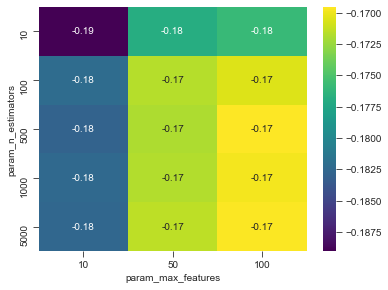

In [203]:
# change index and columns to other parameters to see that param, with all others averaged
ro_piv = pd.pivot_table(ro,  index='param_n_estimators', columns='param_max_features', values='mean_test_score')
sns.heatmap(ro_piv, cmap='viridis', annot=True, )
plt.gcf().set_size_inches(6, 4.5)

In [109]:
rfr_bulk_params.loc[rfr_bulk_params['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,split0_test_score,...,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score,data_subset,y_type
70,0.051877,0.003122,0.028540,0.002773,0.0,5,50,3,10,-0.130124,...,-0.042782,-0.121242,-0.114856,-0.356588,-0.435475,-0.211349,0.109404,1,all,ogtt
401,0.274955,0.012658,0.041459,0.003579,0.0,10,100,3,100,-0.030906,...,-0.055560,-0.019081,-0.041923,-0.078999,-0.074687,-0.046960,0.025172,1,all,weight
671,0.270756,0.011211,0.041119,0.003241,0.0,10,100,3,100,-0.097314,...,-0.076221,-0.133579,-0.131320,-0.237217,-0.189029,-0.166427,0.076911,1,RBG,ogtt
881,0.248636,0.011133,0.042500,0.004187,0.0,5,50,3,100,-0.017408,...,-0.034312,-0.022712,-0.040406,-0.031843,-0.038250,-0.034167,0.018064,1,RBG,weight
1301,0.285546,0.012013,0.041938,0.003133,1.0,5,100,3,100,-0.226803,...,-0.401453,-0.143920,-0.128833,-0.221956,-0.097912,-0.190671,0.106215,1,FBG,ogtt
1566,0.290850,0.009824,0.042138,0.003156,1.0,5,100,2,100,-0.029841,...,-0.072173,-0.057687,-0.054165,-0.054920,-0.018493,-0.043443,0.025046,1,FBG,weight


## Conclusion from broad RF Regressor hyperparam search
### max_features param shows highest importance in improving RFR score 

## Very surprising: Even with only 10 estimators and 10 features, it still achieves OGTT prediction within 2-4 percentage points of the RF with 5000 estimators and 100 features 

### For predicting weight, 10 estimators and 10 features is within 1 percentage of 5k estimators and 100 features

## If it still performs well with 10 estimators and 10 features, what 10 features is it learning?
1. Do .feature_importances_ for lots of trees to get a ranked list of features. 
    1. Use max_features=100, n_estimators=100
2. Take top 100. 
3. Do RFE with CV on those top 100 

In [123]:
fi = {}  # fi = feature importances

for columns, column_name in zip([rbg_cols, fbg_cols], ['RBG', 'FBG']):
    X = X_all.loc[columns]
    fi[column_name] = {}
    for y_data, y_name in zip([y_ogtt, y_weight], ['ogtt', 'weight']):
        y = y_data.loc[columns]
        fi[column_name][y_name] = {}
        for oob_score, oob_score_name in zip([True, False], ['oob_true', 'oob_false']):
            fi[column_name][y_name][oob_score_name] = {}
            d = fi[column_name][y_name][oob_score_name]
            d['feat_imp'] = 0
            for i, (train, test) in enumerate(RepeatedKFold(n_splits=10, n_repeats=10, random_state=1).split(X, y)):
                model = RandomForestRegressor(n_estimators=100, max_features=100, oob_score=oob_score, n_jobs=-1)
                model = model.fit(X.iloc[train], y.iloc[train])
                y_pred = model.predict(X.iloc[test])
                d['feat_imp'] += model.feature_importances_
                d[f'train_{i}'] = train
                d[f'test_{i}'] = test
                d[f'y_true_{i}'] = y.iloc[test]
                d[f'y_pred_{i}'] = y_pred
            

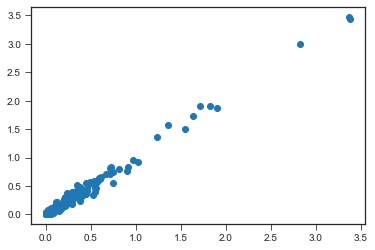

In [168]:
pearsonr(fi['FBG']['ogtt']['oob_true']['feat_imp'], 
         fi['FBG']['ogtt']['oob_false']['feat_imp'])

plt.scatter(fi['FBG']['ogtt']['oob_true']['feat_imp'], fi['FBG']['ogtt']['oob_false']['feat_imp'])

Text(0, 0.5, 'FBG feature importance')

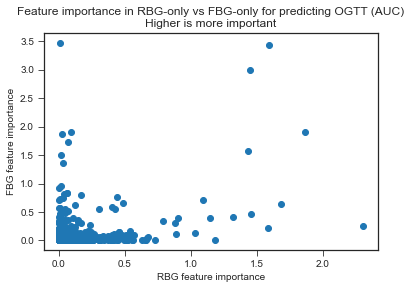

In [209]:
plt.scatter((fi['RBG']['ogtt']['oob_false']['feat_imp']), 
            (fi['FBG']['ogtt']['oob_false']['feat_imp']))
plt.title('Feature importance in RBG-only vs FBG-only for predicting OGTT (AUC)\nHigher is more important')
plt.xlabel('RBG feature importance')
plt.ylabel('FBG feature importance')

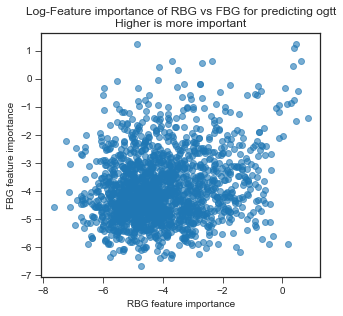

In [191]:
plt.scatter(np.log(fi['RBG']['ogtt']['oob_false']['feat_imp']), 
            np.log(fi['FBG']['ogtt']['oob_false']['feat_imp']), alpha=0.6)
plt.title('Log-Feature importance in RBG-only vs FBG-only for predicting OGTT (AUC)\nHigher is more important', 
          fontsize=12)
plt.xlabel('RBG feature importance')
plt.ylabel('FBG feature importance')
plt.gcf().set_size_inches(5, 4.5)

## Notice the gaussian distribution above. Look at the top right, there seems to be about 15 outliers away from the main distribution 

### pull out features with RBG_feat_imp > 0.7 OR FBG_feat_imp > 1.0 (in regular units, not log-transformed)

In [387]:
fiogtt = pd.DataFrame({'RBG': fi['RBG']['ogtt']['oob_false']['feat_imp'],
              'FBG': fi['FBG']['ogtt']['oob_false']['feat_imp']}, 
              index=model.feature_names_in_)

fiogtt = fiogtt.join(data[['Unique ID', 'Compound Class', 'RT [min]', 'm/z', 'Type']])
fiogtt_filt = fiogtt.loc[(fiogtt['RBG'] > 0.7) | (fiogtt['FBG'] > 0.6)]
fiogtt_filt#.to_clipboard()

,RBG,FBG,Unique ID,Compound Class,RT [min],m/z,Type
l_413,1.183772,0.002803,unknown_1606.17834_9.24,unknown,9.240,1606.17834,lipid
l_572,0.123384,0.630502,Plasmanyl-PC_O-20:0_20:4_824.6543_11.065,Plasmanyl-PC,11.065,824.65430,lipid
l_657,0.890218,0.120706,TG_20:5_22:6_22:6_1014.755_13.093,TG,13.093,1014.75500,lipid
l_669,1.593630,3.427592,unknown_1081.79688_13.387,unknown,13.387,1081.79688,lipid
l_670,1.453769,2.990653,TG_22:6_22:6_22:6_1040.77014_13.389,TG,13.389,1040.77014,lipid
l_706,1.323606,0.417181,unknown_994.77686_14.113,unknown,14.113,994.77686,lipid
l_705,0.904631,0.388472,unknown_1033.79663_14.113,unknown,14.113,1033.79663,lipid
l_707,0.792051,0.350843,TG_18:2_22:6_22:6_997.72522_14.115,TG,14.115,997.72522,lipid
l_708,1.458941,0.468085,unknown_983.78033_14.116,unknown,14.116,983.78033,lipid
l_720,1.685202,0.635221,unknown_1035.81213_14.487,unknown,14.487,1035.81213,lipid


Text(0.5, 1.0, 'Random Forest Regression\nTop-50 Random-fed features')

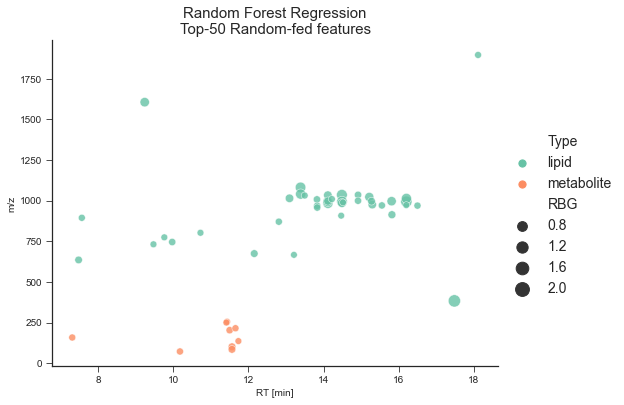

In [391]:
num_features = 50
df = fiogtt.sort_values('RBG', key=abs, ascending=False).iloc[:num_features]
type_colors = {'lipid': colors['lipid'], 'metabolite': colors['metabolite']}
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

sns.scatterplot(data=df, x='RT [min]', y='m/z', 
                hue='Type', alpha=0.8, palette=type_colors,
#                 style='FBGsign', markers={-1: 'X', 1: 's'},
                size=abs(df['RBG']), sizes=(45, 150))
plt.legend(loc=(1.01, 0.2), fontsize=14, markerscale=1.2, )
sns.despine()
plt.title(f'Random Forest Regression\nTop-{num_features} Random-fed features', fontsize=15)

Text(0.5, 1.0, 'Random Forest Regression\nTop-50 Fasted features')

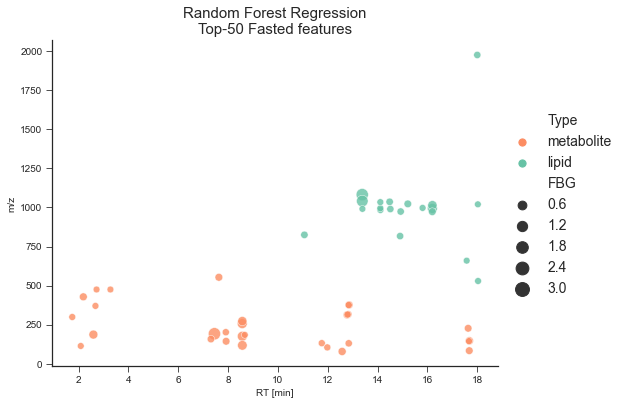

In [392]:
num_features = 50
df = fiogtt.sort_values('FBG', key=abs, ascending=False).iloc[:num_features]
type_colors = {'lipid': colors['lipid'], 'metabolite': colors['metabolite']}
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

sns.scatterplot(data=df, x='RT [min]', y='m/z', 
                hue='Type', alpha=0.8, palette=type_colors,
#                 style='FBGsign', markers={-1: 'X', 1: 's'},
                size=abs(df['FBG']), sizes=(45, 150))
plt.legend(loc=(1.01, 0.2), fontsize=14, markerscale=1.2, )
sns.despine()
plt.title(f'Random Forest Regression\nTop-{num_features} Fasted features', fontsize=15)

In [183]:
fiogtt.loc[fiogtt['Unique ID'].str.contains('Glucose')]

,RBG,FBG,Unique ID,Compound Class,RT [min],m/z
m_103,0.401053,0.023386,D-(+)-Glucose_179.05517_11.565,sugar,11.565,179.05517


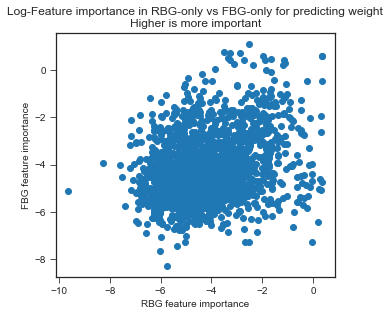

In [196]:
plt.scatter(np.log(fi['RBG']['weight']['oob_false']['feat_imp']), 
            np.log(fi['FBG']['weight']['oob_false']['feat_imp']))
plt.title('Log-Feature importance in RBG-only vs FBG-only for predicting weight\nHigher is more important',
          fontsize=12)
plt.xlabel('RBG feature importance')
plt.ylabel('FBG feature importance')
plt.gcf().set_size_inches(5, 4.5)

In [208]:
fiweight = pd.DataFrame({'RBG': fi['RBG']['weight']['oob_false']['feat_imp'],
              'FBG': fi['FBG']['weight']['oob_false']['feat_imp']}, 
              index=model.feature_names_in_)

fiweight = fiweight.join(data[['Unique ID', 'Compound Class', 'RT [min]', 'm/z']])
fiweight_filt = fiweight.loc[(fiweight['RBG'] > 0.7) | (fiweight['FBG'] > 0.6)]
# fiweight
fiweight_filt.to_clipboard()

In [193]:
len(fiweight_filt.index.intersection(fiogtt_filt.index))

18

In [179]:
pd.merge(left=fiogtt, right=fiweight, left_on=fiogtt.index, right_on=fiweight.index, how='outer',
         suffixes=('_ogtt', '_weight')).head(60)

,key_0,RBG_ogtt,FBG_ogtt,Unique ID_ogtt,Compound Class_ogtt,RT [min]_ogtt,m/z_ogtt,RBG_weight,FBG_weight,Unique ID_weight,Compound Class_weight,RT [min]_weight,m/z_weight
0,l_413,1.183772,0.002803,unknown_1606.17834_9.24,unknown,9.240,1606.17834,0.840469,0.036664,unknown_1606.17834_9.24,unknown,9.240,1606.17834
1,l_572,0.123384,0.630502,Plasmanyl-PC_O-20:0_20:4_824.6543_11.065,Plasmanyl-PC,11.065,824.65430,0.797714,0.626330,Plasmanyl-PC_O-20:0_20:4_824.6543_11.065,Plasmanyl-PC,11.065,824.65430
2,l_657,0.890218,0.120706,TG_20:5_22:6_22:6_1014.755_13.093,TG,13.093,1014.75500,NaN,NaN,NaN,NaN,NaN,NaN
3,l_669,1.593630,3.427592,unknown_1081.79688_13.387,unknown,13.387,1081.79688,0.191314,0.933347,unknown_1081.79688_13.387,unknown,13.387,1081.79688
4,l_670,1.453769,2.990653,TG_22:6_22:6_22:6_1040.77014_13.389,TG,13.389,1040.77014,0.190810,1.594934,TG_22:6_22:6_22:6_1040.77014_13.389,TG,13.389,1040.77014
5,l_706,1.323606,0.417181,unknown_994.77686_14.113,unknown,14.113,994.77686,NaN,NaN,NaN,NaN,NaN,NaN
6,l_705,0.904631,0.388472,unknown_1033.79663_14.113,unknown,14.113,1033.79663,NaN,NaN,NaN,NaN,NaN,NaN
7,l_707,0.792051,0.350843,TG_18:2_22:6_22:6_997.72522_14.115,TG,14.115,997.72522,NaN,NaN,NaN,NaN,NaN,NaN
8,l_708,1.458941,0.468085,unknown_983.78033_14.116,unknown,14.116,983.78033,NaN,NaN,NaN,NaN,NaN,NaN
9,l_720,1.685202,0.635221,unknown_1035.81213_14.487,unknown,14.487,1035.81213,NaN,NaN,NaN,NaN,NaN,NaN


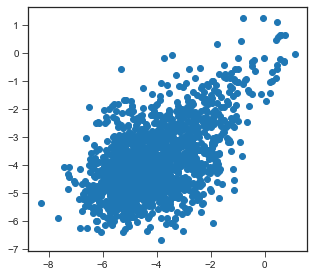

In [200]:
plt.scatter(np.log(fi['FBG']['weight']['oob_false']['feat_imp']), 
            np.log(fi['FBG']['ogtt']['oob_false']['feat_imp']))
# plt.title('Log-Feature importance in RBG-only vs FBG-only for predicting weight\nHigher is more important',
#           fontsize=12)
# plt.xlabel('RBG feature importance')
# plt.ylabel('FBG feature importance')
plt.gcf().set_size_inches(5, 4.5)

## Residuals plot

In [321]:
residuals = []
y_preds = []
y_trues = []
for bg_type in ['RBG']:
    for y_type in ['ogtt']:
        d = fi[bg_type][y_type]['oob_false']
        keys = list(d.keys())[1:]  # skip first to drop feat_imp
        for i in range(100):
            residuals.extend(list(d[f'y_true_{i}'] - d[f'y_pred_{i}']))
            y_trues.extend(list(d[f'y_true_{i}']))
            y_preds.extend(list(d[f'y_pred_{i}']))

<AxesSubplot:>

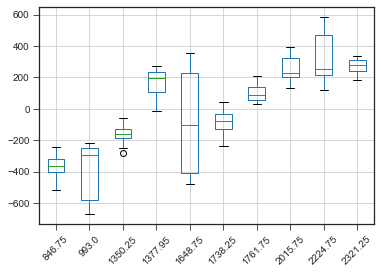

In [322]:
pivot = defaultdict(list)
ogttresid = pd.DataFrame({'true': y_trues, 'residual': residuals})#
for i, row in ogttresid.iterrows():
    pivot[row['true']].append(row['residual'])
pivot = pd.DataFrame(pivot).sort_index(axis=1)
# .boxplot()
pivot.boxplot(rot=45)

Text(0.5, 1.0, 'Bad residuals plot\nrandom-only data predicting OGTT')

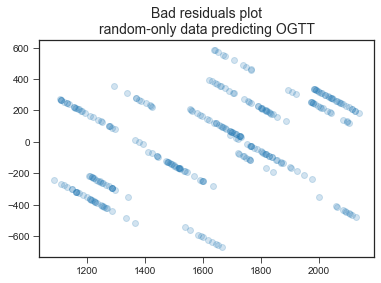

In [369]:
plt.scatter(y_preds, residuals, alpha=0.2)
plt.title('Bad residuals plot\nrandom-only data predicting OGTT', fontsize=14)

# These residuals plots are terrible
It looks like the features have been super duper regularized 

## But read this https://stats.stackexchange.com/questions/180546/random-forest-regression-residuals-correlated-with-response

# Maybe the random forest is learning split points too well, because the train data is likely to have one of the OGTT values present that will be in the test data

# Try doing LeaveOneGroupOut cross-validation 

In [378]:
ld = {}  # ld = LeaveOneGroupOut Dictionary

for columns, column_name in zip([rbg_cols, fbg_cols], ['RBG', 'FBG']):
    X = X_all.loc[columns]
    ld[column_name] = {}
    for y_data, y_name in zip([y_ogtt, y_weight, y_insulin], ['ogtt', 'weight', 'insulin']):
        y = y_data.loc[columns]
        ld[column_name][y_name] = {}
        d = ld[column_name][y_name] = {}
        d['feat_imp'] = 0
        d['y_true'] = []
        d['y_pred'] = []
        logo = LeaveOneGroupOut()
        counter = 0
        for i in range(10):  # n_repeats
            for train, test in logo.split(X, y, groups=X.index.map(fg['animal'])):
                rfr = RandomForestRegressor(n_estimators=100, max_features=100, n_jobs=-1, random_state=i)
                model = rfr.fit(X.iloc[train], y.iloc[train])
                y_pred = model.predict(X.iloc[test])
                d['feat_imp'] += model.feature_importances_
                d['y_true'].extend(y.iloc[test])
                d['y_pred'].extend(y_pred)

Mean absolute percentage error: 21.4 %


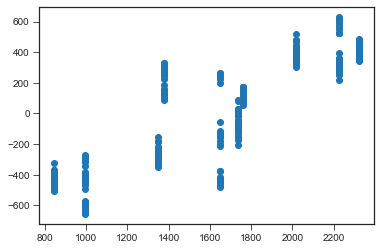

In [383]:
rologo = ld['RBG']['ogtt']  # rologo = RBG OGTT LeaveOneGroupOut
y_pred = np.array(rologo['y_pred'])
y_true = np.array(rologo['y_true'])
resid = y_true - y_pred
print('Mean absolute percentage error:', round(abs(resid / y_true).mean(), 3) * 100, '%') 
plt.scatter(y_true, resid);

Mean absolute percentage error: 22.3 %


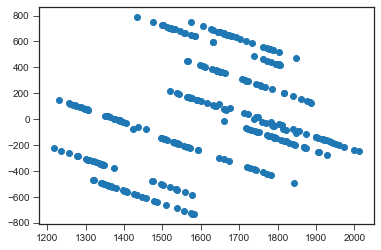

In [380]:
fologo = ld['FBG']['ogtt']  # rologo = RBG OGTT LeaveOneGroupOut
y_pred = np.array(fologo['y_pred'])
y_true = np.array(fologo['y_true'])
resid = y_true - y_pred
print('Mean absolute percentage error:', round(abs(resid / y_true).mean(), 3) * 100, '%') 
plt.scatter(y_pred, resid);

Mean absolute percentage error: 36.5 %


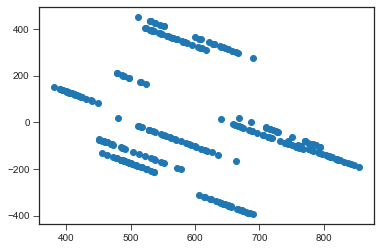

In [381]:
rilogo = ld['RBG']['insulin']  
y_pred = np.array(rilogo['y_pred'])
y_true = np.array(rilogo['y_true'])
resid = y_true - y_pred
print('Mean absolute percentage error:', round(abs(resid / y_true).mean(), 3) * 100, '%') 
plt.scatter(y_pred, resid);

Mean absolute percentage error: 40.5 %


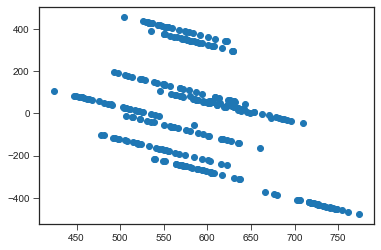

In [382]:
filogo = ld['FBG']['insulin']  
y_pred = np.array(filogo['y_pred'])
y_true = np.array(filogo['y_true'])
resid = y_true - y_pred
print('Mean absolute percentage error:', round(abs(resid / y_true).mean(), 3) * 100, '%') 
plt.scatter(y_pred, resid);

Mean absolute percentage error: 4.3 %


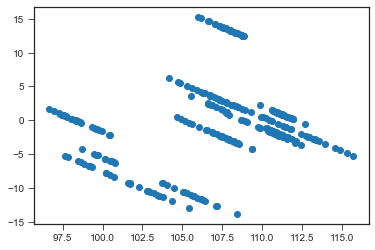

In [374]:
rwlogo = ld['RBG']['weight']  # rologo = RBG OGTT LeaveOneGroupOut
y_pred = np.array(rwlogo['y_pred'])
y_true = np.array(rwlogo['y_true'])
resid = y_true - y_pred
print('Mean absolute percentage error:', round(abs(resid / y_true).mean(), 3) * 100, '%') 
plt.scatter(y_pred, resid);

Mean absolute percentage error: 5.2 %


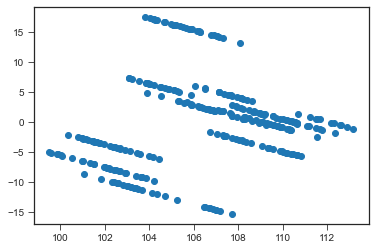

In [375]:
fwlogo = ld['FBG']['weight']  # rologo = RBG OGTT LeaveOneGroupOut
y_pred = np.array(fwlogo['y_pred'])
y_true = np.array(fwlogo['y_true'])
resid = y_true - y_pred
print('Mean absolute percentage error:', round(abs(resid / y_true).mean(), 3) * 100, '%') 
plt.scatter(y_pred, resid);

# old analysis below

# Grid Search CV Hyperparameter optimization

In [13]:
cv_bg = RepeatedKFold(n_splits=6, n_repeats=10, random_state=1)     # 50 X, 10 y
cv_fr = RepeatedKFold(n_splits=6, n_repeats=10, random_state=1)     # 25 X, 5 y
cv_loo_fr = RepeatedKFold(n_splits=30, n_repeats=1, random_state=1) # 29 X, 1 y
# for i in cv_loo_fr.split(f.T, y_bg.loc[fbg_cols]):
#     print(i)

rfr = RandomForestRegressor(n_jobs=7)

params = {
    'n_estimators': [500, 1000, 1500, 2000, 3000],
    'max_features': [20, 30, 40, 50, 60, 80, 100]}

rfr_gs = GridSearchCV(estimator=rfr,
                     param_grid=params,
                     scoring='r2',
                     cv=cv_bg,
                     n_jobs=7,)
rfr_result = rfr_gs.fit(X_all, y_bg)
# summarize results
print("Best: %f using %s" % (rfr_result.best_score_, rfr_result.best_params_))
means = rfr_result.cv_results_['mean_test_score']
stds = rfr_result.cv_results_['std_test_score']
params = rfr_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KeyboardInterrupt: 

In [23]:
l = []
for mean, param in zip(means, params):
    d = {'mean': mean, **param}
    l.append(d)
rfrgsresult = pd.DataFrame(l)

rfrgsresult.groupby('max_features').mean()

,mean,n_estimators
max_features,,
20,0.710604,1600.0
30,0.728195,1600.0
40,0.738740,1600.0
50,0.745875,1600.0
60,0.750917,1600.0
80,0.757312,1600.0
100,0.759870,1600.0


# GridSearch Conclusion:
## 1. max_features of 60, 80, and 100 are better than the default sqrt(n_features) = 40
###  80 and 100 are approximately the same, but slightly better than 60, so use max_features = 80
## 2. No relationship between score and n_estimators, so use 1,000

# Task 1:
## Predict OGTT AUC 
## Compare predictive power of 
### (1) random-only 
### (2) fasted-only 
### (3) all data

## (1)

In [5]:
rfr = RandomForestRegressor(n_estimators=1000, max_features=80)
rbg_scores = cross_val_score(rfr, 
                           X_all.loc[rbg_cols], 
                           y_ogtt.loc[rbg_cols], 
                           scoring='neg_mean_absolute_error', 
                           cv=cv_loo_fr, 
                           n_jobs=7, 
                           error_score='raise')

NameError: name 'cv_loo_fr' is not defined

Mean Absolute Error:   229.91919499999946
Median Absolute Error: 223.1510750000008
Standard Dev: 		134.16259718973288


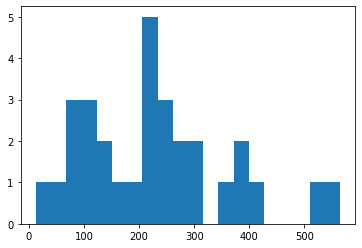

In [64]:
print(f'Mean Absolute Error:   {np.mean(-1*rbg_scores)}\n'
      f'Median Absolute Error: {np.median(-1*rbg_scores)}\n'
      f'Standard Dev: \t\t{np.std(rbg_scores)}')
plt.hist(-1*rbg_scores, bins=20);

## (2)

In [52]:
rfr = RandomForestRegressor(n_estimators=1000, max_features=80)
fbg_scores = cross_val_score(rfr, 
                           X_all.loc[fbg_cols], 
                           y_ogtt.loc[fbg_cols], 
                           scoring='neg_mean_absolute_error', 
                           cv=cv_loo_fr, 
                           n_jobs=7, 
                           error_score='raise')

Mean Absolute Error:   272.24621166666617
Median Absolute Error: 219.10134999999673
Standard Dev: 		202.54627812191006


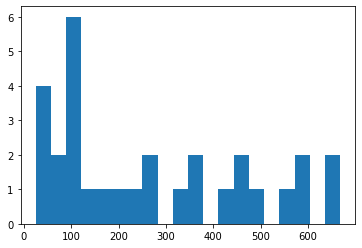

In [62]:
print(f'Mean Absolute Error:   {np.mean(-1*fbg_scores)}\n'
      f'Median Absolute Error: {np.median(-1*fbg_scores)}\n'
      f'Standard Dev: \t\t{np.std(fbg_scores)}')
plt.hist(-1*fbg_scores, bins=20);

## (3)

In [65]:
rfr = RandomForestRegressor(n_estimators=1000, max_features=80)
all_samples_scores = cross_val_score(rfr, 
                           X_all, 
                           y_ogtt, 
                           scoring='neg_mean_absolute_error', 
                           cv=60, 
                           n_jobs=7, 
                           error_score='raise')

Mean Absolute Error:   230.21051666666642
Median Absolute Error: 220.10967499999958
Standard Dev: 		162.49521698585613


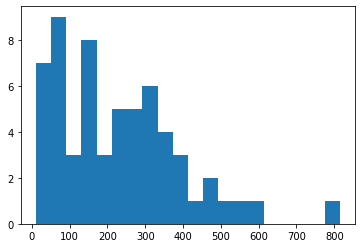

In [66]:
print(f'Mean Absolute Error:   {np.mean(-1*all_samples_scores)}\n'
      f'Median Absolute Error: {np.median(-1*all_samples_scores)}\n'
      f'Standard Dev: \t\t{np.std(all_samples_scores)}')
plt.hist(-1*all_samples_scores, bins=20);

<Figure size 432x288 with 0 Axes>

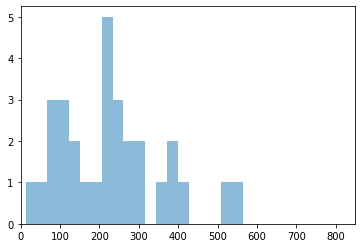

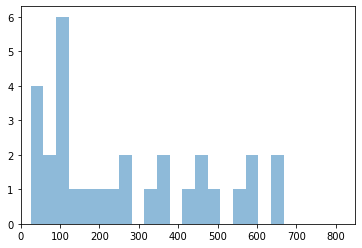

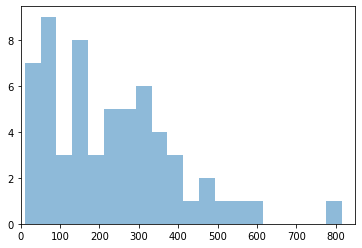

<Figure size 432x288 with 0 Axes>

In [72]:
plt.hist(-1*rbg_scores, alpha=0.5, bins=20)
plt.xlim(0, 850)
plt.figure()
plt.hist(-1*fbg_scores, alpha=0.5, bins=20)
plt.xlim(0, 850)
plt.figure()
plt.hist(-1*all_samples_scores, alpha=0.5, bins=20)
plt.xlim(0, 850)
plt.figure()

# RUN SAME EXPERIMENT WITH DIFFERENT ERRORS:
1. neg_root_mean_squared_error
2. neg_mean_absolute_percentage_error

In [171]:
cv_10 = RepeatedKFold(n_splits=10, n_repeats=30, random_state=1)

In [172]:
rfr = RandomForestRegressor(n_estimators=1000, max_features=80)
rbg_scores = cross_val_score(rfr, 
                           X_all.loc[rbg_cols], 
                           y_ogtt.loc[rbg_cols], 
                           scoring='neg_mean_absolute_percentage_error', 
                           cv=cv_10, 
                           n_jobs=7, 
                           error_score='raise')

Mean Absolute Error:   0.17016680793531636
Median Absolute Error: 0.15404092300663508
Standard Dev: 		0.08007214783435972


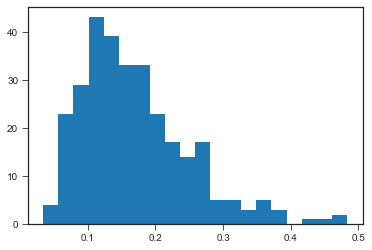

In [173]:
print(f'Mean Absolute Error:   {np.mean(-1*rbg_scores)}\n'
      f'Median Absolute Error: {np.median(-1*rbg_scores)}\n'
      f'Standard Dev: \t\t{np.std(rbg_scores)}')
plt.hist(-1*rbg_scores, bins=20);

## (2)

In [174]:
rfr = RandomForestRegressor(n_estimators=1000, max_features=80)
fbg_scores = cross_val_score(rfr, 
                           X_all.loc[fbg_cols], 
                           y_ogtt.loc[fbg_cols], 
                           scoring='neg_mean_absolute_percentage_error', 
                           cv=cv_10, 
                           n_jobs=7, 
                           error_score='raise')

Mean Absolute Error:   0.1955104931610371
Median Absolute Error: 0.1671712819285167
Standard Dev:          0.10865026250116547


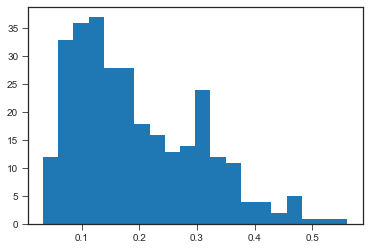

In [175]:
print(f'Mean Absolute Error:   {np.mean(-1*fbg_scores)}\n'
      f'Median Absolute Error: {np.median(-1*fbg_scores)}\n'
      f'Standard Dev:          {np.std(fbg_scores)}')
plt.hist(-1*fbg_scores, bins=20);

## (3)

In [176]:
rfr = RandomForestRegressor(n_estimators=1000, max_features=80)
all_samples_scores = cross_val_score(rfr, 
                           X_all, 
                           y_ogtt, 
                           scoring='neg_mean_absolute_percentage_error', 
                           cv=cv_10, 
                           n_jobs=7, 
                           error_score='raise')

Mean Absolute Error:   0.1693142208482454
Median Absolute Error: 0.15381555043824757
Standard Dev: 		0.06719771613057929


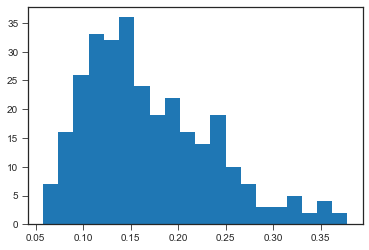

In [177]:
print(f'Mean Absolute Error:   {np.mean(-1*all_samples_scores)}\n'
      f'Median Absolute Error: {np.median(-1*all_samples_scores)}\n'
      f'Standard Dev: \t\t{np.std(all_samples_scores)}')
plt.hist(-1*all_samples_scores, bins=20);

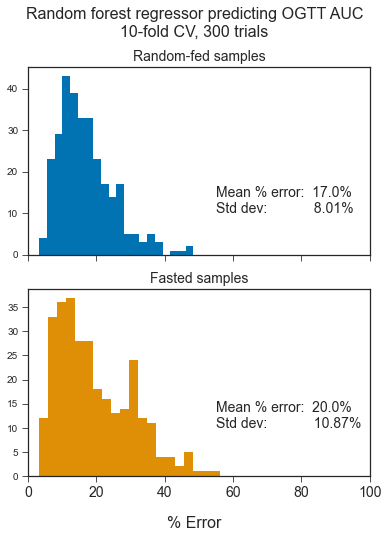

In [196]:
def annotate_ax(ax, scores):
    ax.annotate(
      f'Mean % error:  {round(np.mean(-1*scores), 2) * 100}%\n'
#       f'Median: {round(np.median(-1*scores), 2) * 100}%\n'
      f'Std dev:            {round(np.std(scores) * 100, 2)}%',
      xy=(0.55, 10), fontsize=14)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(5.5, 7.5))
# fig.tight_layout()
fig.suptitle('Random forest regressor predicting OGTT AUC\n10-fold CV, 300 trials', fontsize=16)
fig.supxlabel('% Error', fontsize=16)

ax1.hist(-1*rbg_scores, bins=20, color=colors['RBG'])
ax1.set_title('Random-fed samples', fontsize=14)
# ax1.annotate(f'Mean: ', xy=(0.8, 0.8), fontsize=16)
annotate_ax(ax1, rbg_scores)

ax2.hist(-1*fbg_scores, bins=20, color=colors['FBG'])
ax2.set_title('Fasted samples', fontsize=14)
annotate_ax(ax2, fbg_scores)

ax2.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1,])
ax2.set_xticklabels(['0', '20', '40', '60', '80', '100'], fontsize=14);

plt.tight_layout()

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


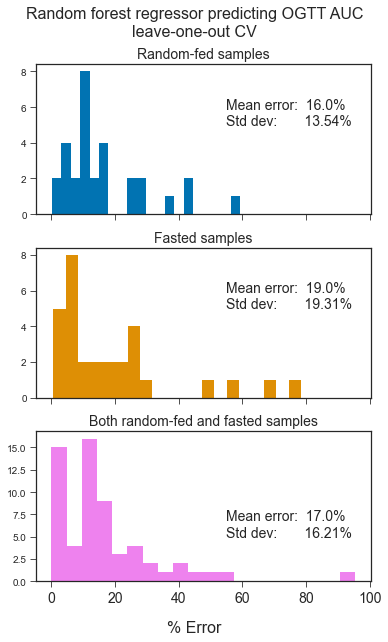

In [162]:
def annotate_ax(ax, scores):
    ax.annotate(
      f'Mean error:  {round(np.mean(-1*scores), 2) * 100}%\n'
#       f'Median: {round(np.median(-1*scores), 2) * 100}%\n'
      f'Std dev:       {round(np.std(scores) * 100, 2)}%',
      xy=(0.55, 5), fontsize=14)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(5.5, 9))
# fig.tight_layout()
fig.suptitle('Random forest regressor predicting OGTT AUC\nleave-one-out CV', fontsize=16)
fig.supxlabel('% Error', fontsize=16)

ax1.hist(-1*rbg_scores, bins=20, color=colors['RBG'])
ax1.set_title('Random-fed samples', fontsize=14)
# ax1.annotate(f'Mean: ', xy=(0.8, 0.8), fontsize=16)
annotate_ax(ax1, rbg_scores)

ax2.hist(-1*fbg_scores, bins=20, color=colors['FBG'])
ax2.set_title('Fasted samples', fontsize=14)
annotate_ax(ax2, fbg_scores)

ax3.hist(-1*all_samples_scores, bins=20, color='violet')
ax3.set_title('Both random-fed and fasted samples', fontsize=14)
ax3.set_xticklabels(['', '0', '20', '40', '60', '80', '100'], fontsize=14);
annotate_ax(ax3, all_samples_scores)

plt.tight_layout()

# Conclusion from Random Forest Regressor

Both leave-one-out and 10-fold CV show that random has a better mean % error than fasted

# Task 2:
## Permutation importance using clustered features 
### Ward clustering: 
Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering

### Within each cluster, get feature labels and choose the feature that has the most significant p-value under glucose_tolerance as the representative feature for the random forest model. 

### Try a number of different clustering params that vary the number of clusters.
### We could try 90% reduction in num_features (172) for a more focussed look at features
### We could reduce by 50% to 864, or maybe 500. 

In [217]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)
    return counts

In [58]:
ac = AgglomerativeClustering(n_clusters=500, linkage='ward', compute_distances=True).fit(X_all.T)
fc500 = FeatureAgglomeration(n_clusters=500, linkage='ward', compute_distances=True).fit(X_all)

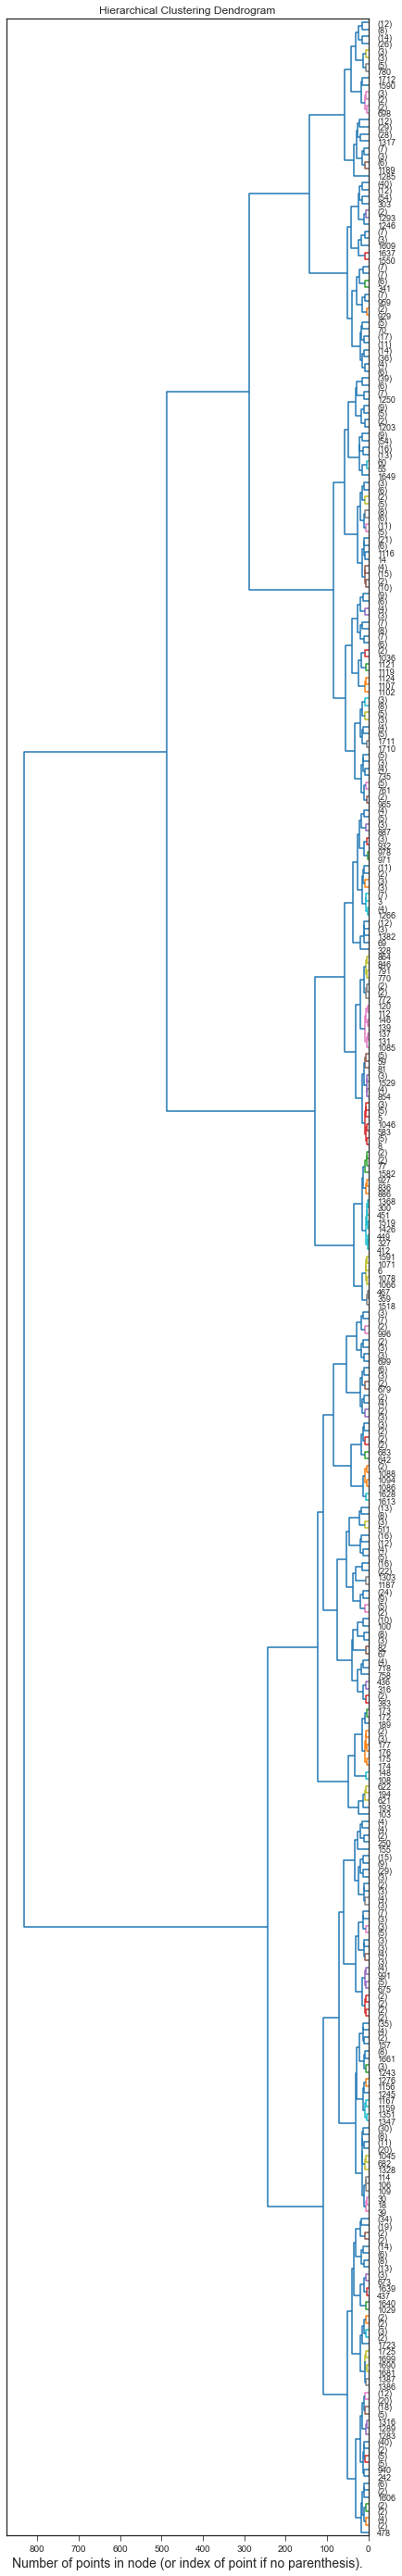

In [80]:
counts = plot_dendrogram(fc500, 
                p=8, 
                truncate_mode='level', 
                color_threshold=9,
                orientation='left',)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Number of points in node (or index of point if no parenthesis).", fontsize=14)
plt.yticks(fontsize=9)
plt.gcf().set_size_inches(7, 50)

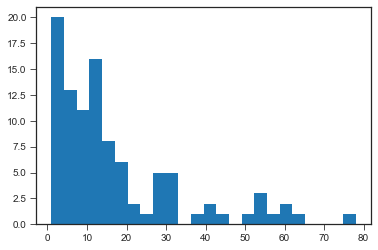

In [179]:
fc100 = FeatureAgglomeration(n_clusters=100, linkage='ward', compute_distances=True).fit(X_all)
fc400 = FeatureAgglomeration(n_clusters=400, linkage='ward', compute_distances=True).fit(X_all)

index_to_metabolite_map = {i: x for i, x in enumerate(X_all.columns)}

counts100 = defaultdict(lambda: 0)
members100 = defaultdict(list)
for metabolite_index, group_num in enumerate(fc100.labels_):
    counts100[group_num] += 1
    members100[group_num].append(index_to_metabolite_map[metabolite_index])
plt.hist(list(counts100.values()), bins=24)

counts400 = defaultdict(lambda: 0)
members400 = defaultdict(list)
for metabolite_index, group_num in enumerate(fc400.labels_):
    counts400[group_num] += 1
    members400[group_num].append(index_to_metabolite_map[metabolite_index])

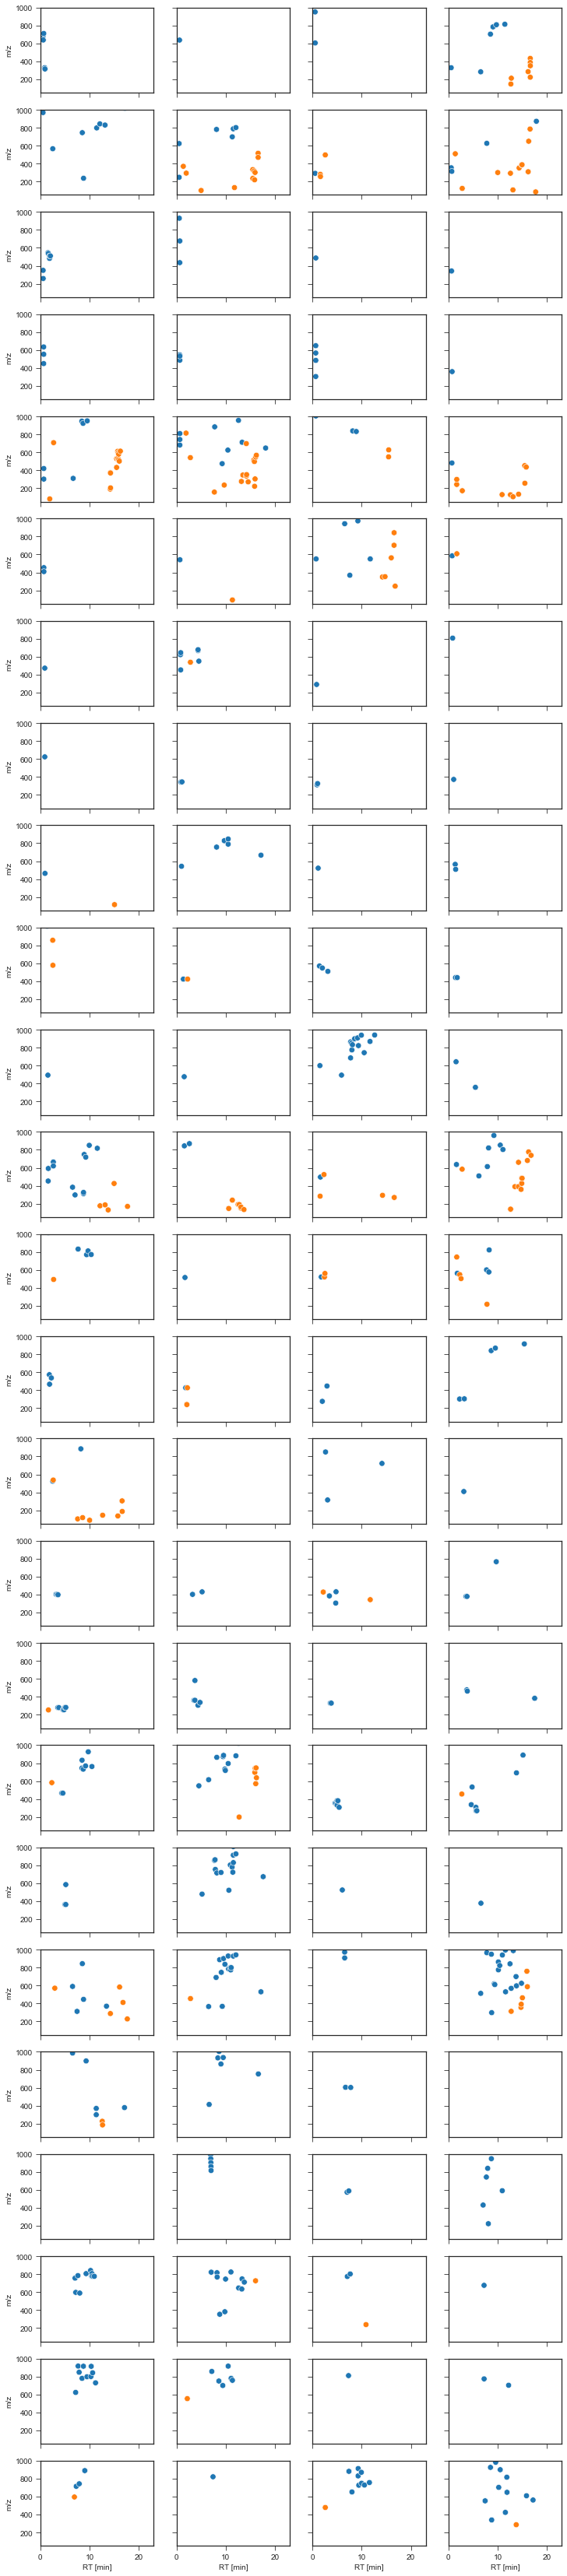

In [185]:
ncols = 4
fig, axs = plt.subplots(nrows=25, ncols=ncols, figsize=(12, 60), sharex=True, sharey=True, facecolor=(1,1,1))

for i, group in enumerate(members400):
    row = math.floor(i/ncols)
    col = i % ncols
    ax = axs[row][col]
    tdf = data.loc[members400[group]]
    sns.scatterplot(data=tdf, x='RT [min]', y='m/z', hue='Type', s=55, legend=False, ax=ax)
    ax.set_xlim(0, 23)
    ax.set_ylim(50, 1000)    
    if i == 99:
        break

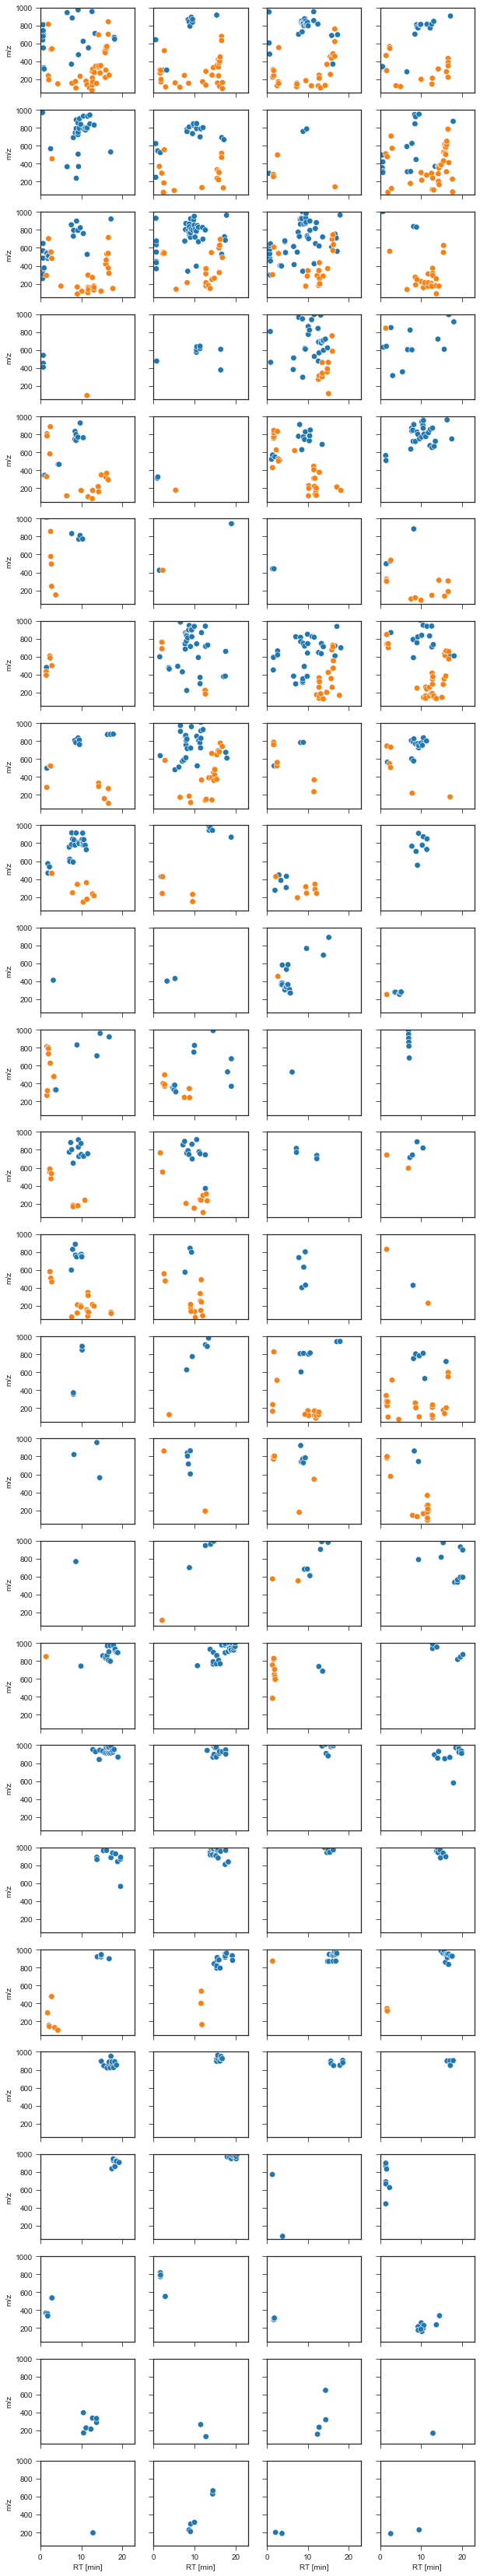

In [183]:
fig, axs = plt.subplots(nrows=25, ncols=4, figsize=(10, 60), sharex=True, sharey=True, facecolor=(1,1,1))
for i, group in enumerate(members):
    row = math.floor(i/4)
    col = i % 4
    ax = axs[row][col]
    tdf = data.loc[members[group]]
    sns.scatterplot(data=tdf, x='RT [min]', y='m/z', hue='Type', s=55, legend=False, ax=ax)
    ax.set_xlim(0, 23)
    ax.set_ylim(50, 1000)    

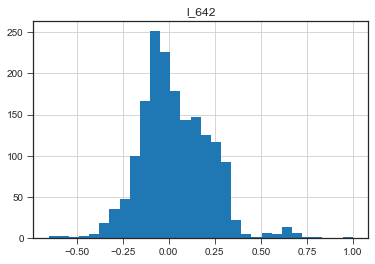

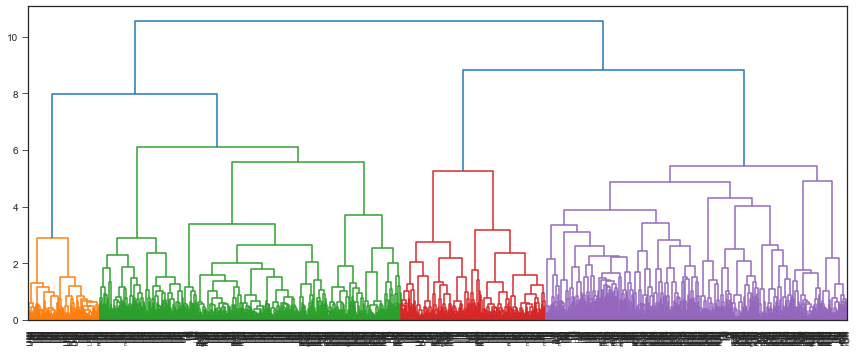

In [211]:
# Takes about 10 minutes to calculate kendall and spearman
# corr_kendall = X_all.corr('kendall')
# corr_spearman = X_all.corr('spearman')
corr_pearson = X_all.corr('pearson')
# corr_kendall.to_csv(r'..\data\processed\correlations\kendall.csv')
# corr_spearman.to_csv(r'..\data\processed\correlations\spearman.csv')
corr_pearson.to_csv(r'..\data\processed\correlations\pearson.csv')
corr_kendall = pd.read_csv(r'..\data\processed\correlations\kendall.csv', index_col=0)
corr_spearman = pd.read_csv(r'..\data\processed\correlations\spearman.csv', index_col=0)
corr_pearson = pd.read_csv(r'..\data\processed\correlations\pearson.csv', index_col=0)
corr_kendall.sample(axis=1).hist(bins=30)


# Example from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
corr = corr_kendall.values

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_all.columns, ax=ax, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

# ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
# ax2.set_xticks(dendro_idx)
# ax2.set_yticks(dendro_idx)
# ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
# ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

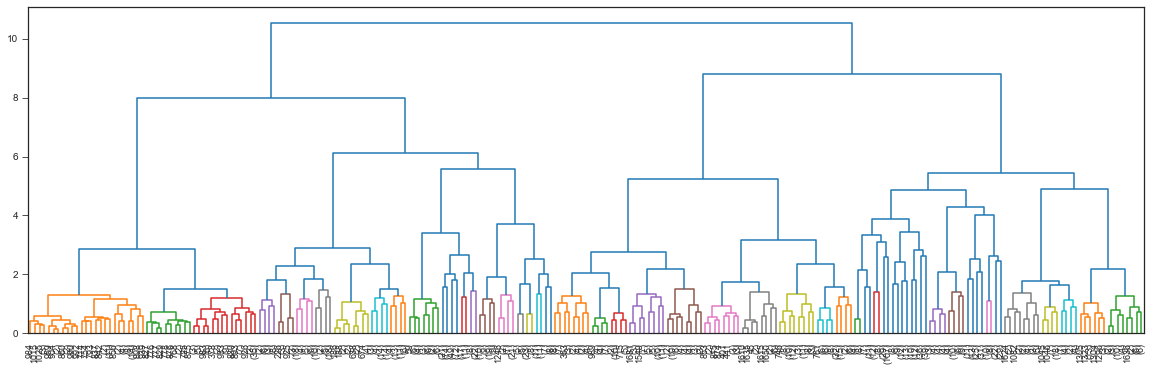

In [124]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
# ax.set_xticks(ticks=[None]*1729)
dendro = hierarchy.dendrogram(
    dist_linkage, 
    p=7,
    truncate_mode='level',
    color_threshold=1.5,
#     labels=data.feature_names.tolist(), 
    labels=None,
    ax=ax, 
    leaf_rotation=90,)
plt.xticks(fontsize=9);

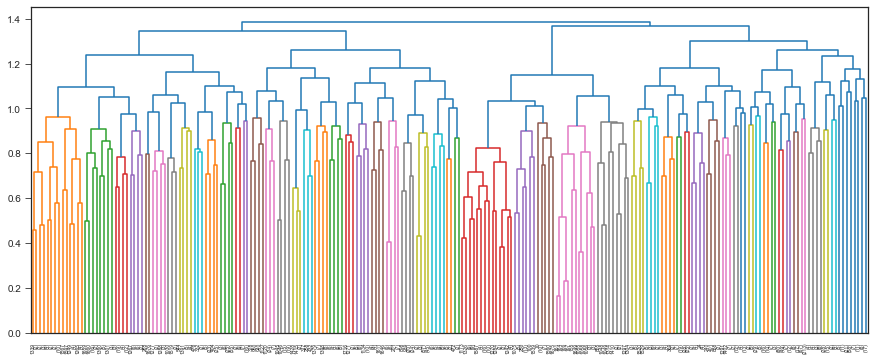

In [241]:
pc = FeatureAgglomeration(n_clusters=100, affinity='precomputed', 
                          linkage='complete', compute_distances=True).fit(np.sqrt(1 - corr_pearson))
pc
plot_dendrogram(pc, truncate_mode='level', p=7)
plt.gcf().set_size_inches(15, 6)

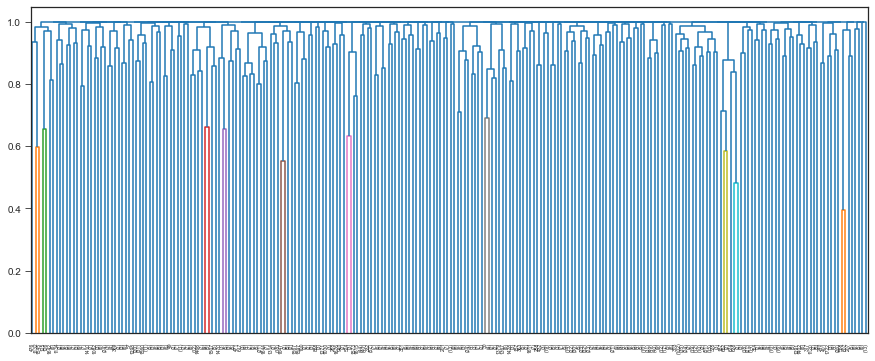

In [244]:
pc = FeatureAgglomeration(n_clusters=100, 
                          affinity='precomputed', 
                          linkage='complete', 
                          compute_distances=True).fit(np.sqrt(1 - corr_pearson**2))
plot_dendrogram(pc, truncate_mode='level', p=7)
plt.gcf().set_size_inches(15, 6)

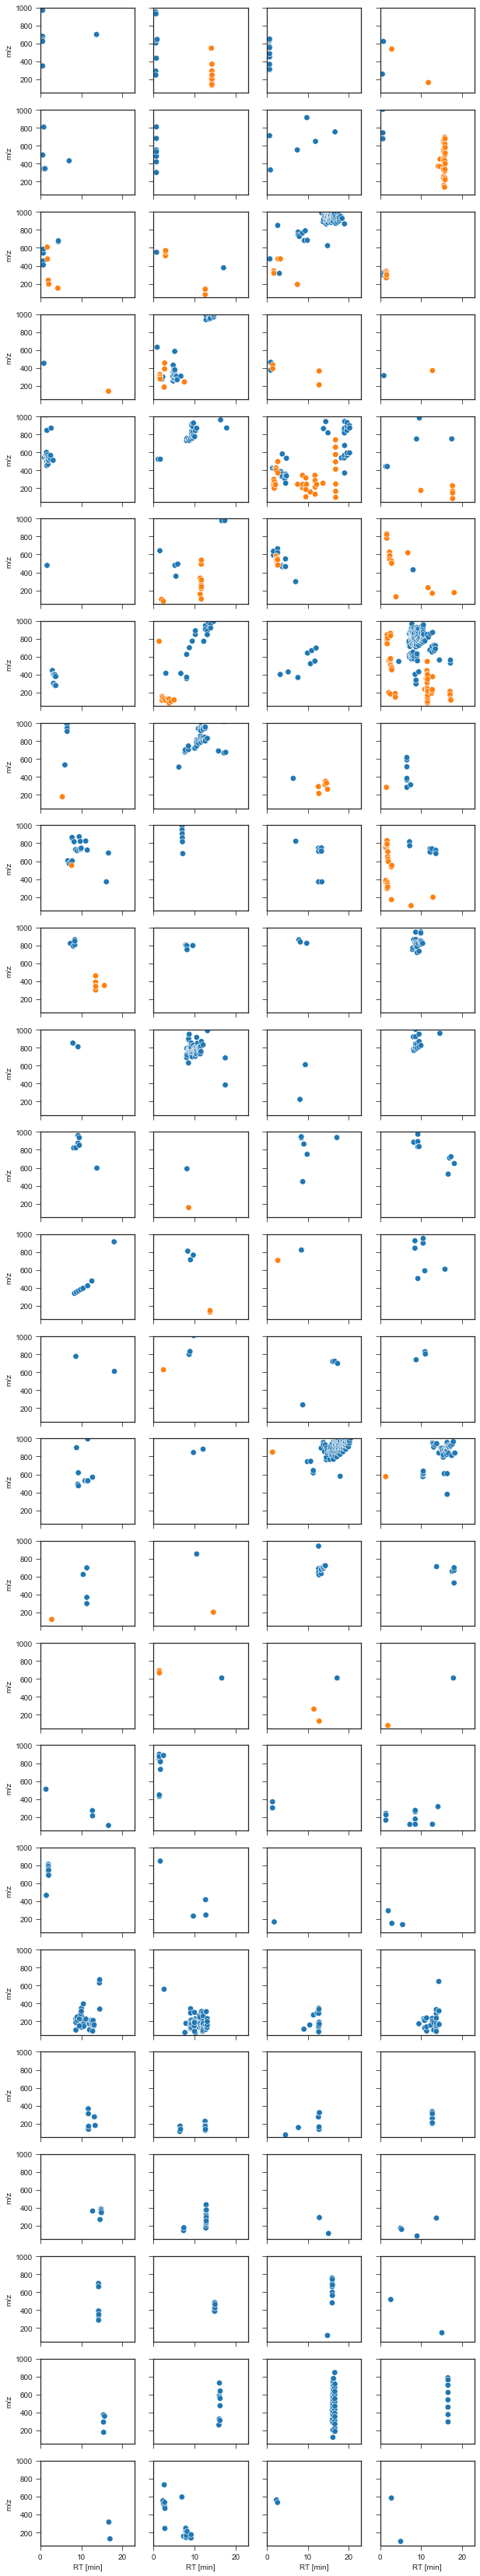

In [243]:
pc100_counts = defaultdict(lambda: 0)
pc100_members = defaultdict(list)
for metabolite_index, group_num in enumerate(pc.labels_):
    pc100_counts[group_num] += 1
    pc100_members[group_num].append(index_to_metabolite_map[metabolite_index])
    
fig, axs = plt.subplots(nrows=25, ncols=4, figsize=(10, 60), sharex=True, sharey=True, facecolor=(1,1,1))
for i, group in enumerate(pc100_members):
    row = math.floor(i/4)
    col = i % 4
    ax = axs[row][col]
    tdf = data.loc[pc100_members[group]]
    sns.scatterplot(data=tdf, x='RT [min]', y='m/z', hue='Type', s=55, legend=False, ax=ax)
    ax.set_xlim(0, 23)
    ax.set_ylim(50, 1000)  

,fdr corrected pval effect of glucose tolerance,fdr corrected pval effect of sampling
i,,
l_47,0.030658,0.442397
l_55,0.034315,0.368608
l_60,0.016949,0.304811
m_47,0.833771,0.446780
m_54,0.185407,0.471561
m_14,0.820151,0.734549
m_20,0.050676,0.355050
m_16,0.084826,0.539735
m_45,0.073038,0.563509


0.0169490622543246

0.3048114819611204

0.23664354505308804


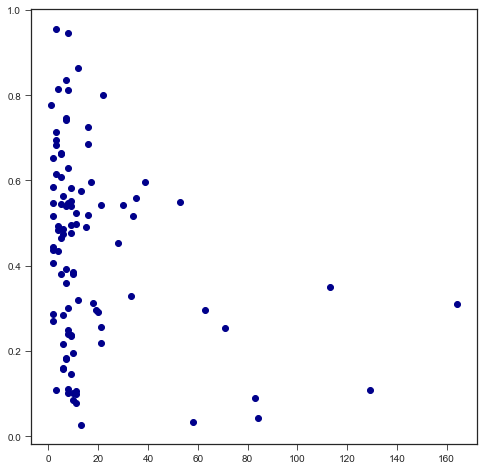

In [256]:
gtcol = 'fdr corrected pval effect of glucose tolerance'
scol = 'fdr corrected pval effect of sampling'
group = 36
display(data.loc[pc100_members[group], [gtcol, scol]])
display(data.loc[pc100_members[group], gtcol].min())
display(data.loc[pc100_members[group], scol].min())
print(data.loc[pc100_members[group], gtcol].mean())

for group, members in pc100_members.items():
    num_members = len(members)
    mean = data.loc[pc100_members[group], gtcol].mean()
    plt.scatter(num_members, mean, c='darkblue')
plt.gcf().set_size_inches(8, 8)

In [258]:
feats100 = []

for group, members in pc100_members.items():
    num_members = len(members)
    best_feat = data.loc[pc100_members[group], gtcol].idxmin()
    feats100.append(best_feat)

In [261]:
i = 1
for x in feats100:
    if 'l' in x:
        i += 1
print('Number of lipids that are the best feature in each group:', i)

Number of lipids that are the best feature in each group: 53


# Conclusion after all these clustering plots

## Typical hierarchical clustering methods use euclidian distance. This may have benefits elsewhere, but for feature reduction, correlation (i.e. Pearson correlation) is superior, as given by the inidividual group's MZ/RT plots. 

# Task 2: 
## Permutation importance on clustered features 

# Are the features important under Fasted-only model the same as Random-only model? 

https://scikit-learn.org/stable/modules/permutation_importance.html

https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

https://scikit-learn.org/stable/auto_examples/model_selection/plot_permutation_tests_for_classification.html#sphx-glr-auto-examples-model-selection-plot-permutation-tests-for-classification-py

## With 100 features, we need to re-do the CVGridSearch

# Stopping point 2/14/22
## Make a grid_search function 

In [265]:
def grid_search(X, y, model, params, cv, scoring):
    gs = GridSearchCV(estimator=model,
                      param_grid=params,
                      scoring=scoring,
                      cv=cv,
                      n_jobs=7,)
    result = gs.fit(X, y)
    print("Best: %f using %s" % (result.best_score_, result.best_params_))
    means = result.cv_results_['mean_test_score']
    stds = result.cv_results_['std_test_score']
    params = result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    l = []
    for mean, param in zip(means, params):
        d = {'mean': mean, **param}
        l.append(d)
    return pd.DataFrame(l)

i,l_684,m_320,l_17,l_46,l_53,l_38,l_856,m_579,l_41,m_251,...,m_665,m_267,m_117,m_701,m_642,m_691,m_609,m_611,m_239,m_63
1076_10_FBG,18.579026,23.539123,18.324009,19.745809,26.676519,22.549608,18.938871,21.212959,20.367622,23.468767,...,20.420203,24.365076,23.366573,19.182983,21.133735,20.014256,20.735123,21.247585,23.432970,25.401925
1062_8_FBG,19.355461,24.000482,21.428115,20.974239,24.299812,24.178958,20.186790,21.158338,22.920641,22.781531,...,20.763225,23.083290,22.713420,19.717326,20.956177,19.109210,19.924224,20.729395,22.973063,26.012743
1093_9_FBG,19.562949,23.842228,21.761263,20.067317,26.357983,23.737911,20.238083,21.374062,21.519668,23.943484,...,20.575236,22.980335,22.935490,19.632241,21.139571,19.753037,20.724401,21.246916,23.392969,26.308371
1060_8_RBG,19.680168,23.788970,22.087831,21.114056,25.690836,24.592638,20.300247,21.228774,23.550025,22.888485,...,21.027209,23.240312,22.964192,19.559839,19.922426,20.048586,20.659059,21.306620,23.227831,25.996940
1091_10_FBG,19.631501,23.785056,22.250819,19.764036,25.544788,23.952803,20.531164,21.147437,22.045318,24.265623,...,20.655922,23.182329,22.831952,19.599573,21.297688,19.861723,21.013883,21.272943,23.431834,26.104542
1092_9_RBG,19.483137,23.668997,21.391864,20.444276,25.756593,23.808030,20.015996,21.237580,21.330123,22.995023,...,20.456004,24.199037,23.598836,19.339518,21.097619,19.806535,20.793372,21.149575,22.253683,26.043090
1093_10_RBG,19.639468,23.569195,21.373437,19.973237,25.907885,23.997328,20.325593,21.166290,21.995964,23.552520,...,20.365105,23.872516,23.063571,19.871974,21.148515,19.898837,20.944760,21.055487,23.525612,26.246791
1082_10_FBG,19.720891,23.664031,21.350521,19.818512,25.555032,23.883112,20.341686,21.516908,21.588590,23.520591,...,20.847346,24.035530,22.753860,18.965590,21.139149,20.110493,20.869389,21.100264,23.366226,26.087400
1060_9_RBG,19.681545,23.159190,22.168219,21.375607,25.419501,23.159195,20.437337,20.705267,18.944169,24.038859,...,20.827570,23.835508,24.000691,20.407732,21.401375,19.729391,21.714082,21.167661,23.479085,26.557365
1101_9_FBG,19.768773,23.922542,21.537200,20.213458,25.355211,24.247718,19.832739,21.356330,22.088382,24.124994,...,20.795632,23.904301,22.885133,19.285396,20.993106,20.057292,20.962475,21.083071,23.487285,26.116650


In [268]:
# cv_bg = RepeatedKFold(n_splits=6, n_repeats=10, random_state=1)     # 50 X, 10 y
# cv_fr = RepeatedKFold(n_splits=6, n_repeats=10, random_state=1)     # 25 X, 5 y
# cv_loo_fr = RepeatedKFold(n_splits=30, n_repeats=1, random_state=1) # 29 X, 1 y
rfr = RandomForestRegressor(n_jobs=7)
params = {
    'n_estimators': [100, 500, 1000, 1500, 2000],
    'max_features': [5, 10, 15, 20, 30, 40]}
scoring = 'neg_mean_absolute_percentage_error'
cv = 10

gs_100_feats = grid_search(X_all[feats100], y_ogtt, 
                           model=rfr,
                           params=params,
                           cv=cv,
                           scoring=scoring)

Best: -0.170875 using {'max_features': 40, 'n_estimators': 1000}
-0.194053 (0.051937) with: {'max_features': 5, 'n_estimators': 100}
-0.191347 (0.050341) with: {'max_features': 5, 'n_estimators': 500}
-0.191087 (0.050670) with: {'max_features': 5, 'n_estimators': 1000}
-0.187445 (0.049282) with: {'max_features': 5, 'n_estimators': 1500}
-0.190143 (0.049899) with: {'max_features': 5, 'n_estimators': 2000}
-0.181022 (0.051618) with: {'max_features': 10, 'n_estimators': 100}
-0.180946 (0.049306) with: {'max_features': 10, 'n_estimators': 500}
-0.179689 (0.047431) with: {'max_features': 10, 'n_estimators': 1000}
-0.182289 (0.050377) with: {'max_features': 10, 'n_estimators': 1500}
-0.180377 (0.049689) with: {'max_features': 10, 'n_estimators': 2000}
-0.180413 (0.049902) with: {'max_features': 15, 'n_estimators': 100}
-0.178643 (0.048819) with: {'max_features': 15, 'n_estimators': 500}
-0.178151 (0.049294) with: {'max_features': 15, 'n_estimators': 1000}
-0.176997 (0.048477) with: {'max_fea

In [269]:
gs_100_feats

,mean,max_features,n_estimators
0,-0.194053,5,100
1,-0.191347,5,500
2,-0.191087,5,1000
3,-0.187445,5,1500
4,-0.190143,5,2000
5,-0.181022,10,100
6,-0.180946,10,500
7,-0.179689,10,1000
8,-0.182289,10,1500
9,-0.180377,10,2000


In [271]:
rfr = RandomForestRegressor(n_jobs=7)
params = {
    'n_estimators': [100, 200, 400, 700, 1000],
    'max_depth': [2, 4, 6, 8, 10],
    'max_features': [20, 30, 40, 50, 60]}
scoring = 'neg_mean_absolute_percentage_error'
cv = 10

gs_100_2 = grid_search(X_all[feats100], y_ogtt, 
                           model=rfr,
                           params=params,
                           cv=cv,
                           scoring=scoring)

Best: -0.166076 using {'max_depth': 10, 'max_features': 60, 'n_estimators': 100}
-0.188190 (0.046455) with: {'max_depth': 2, 'max_features': 20, 'n_estimators': 100}
-0.186678 (0.049077) with: {'max_depth': 2, 'max_features': 20, 'n_estimators': 200}
-0.188866 (0.047057) with: {'max_depth': 2, 'max_features': 20, 'n_estimators': 400}
-0.191441 (0.049887) with: {'max_depth': 2, 'max_features': 20, 'n_estimators': 700}
-0.187641 (0.048391) with: {'max_depth': 2, 'max_features': 20, 'n_estimators': 1000}
-0.191187 (0.050837) with: {'max_depth': 2, 'max_features': 30, 'n_estimators': 100}
-0.183923 (0.046577) with: {'max_depth': 2, 'max_features': 30, 'n_estimators': 200}
-0.185439 (0.048803) with: {'max_depth': 2, 'max_features': 30, 'n_estimators': 400}
-0.182559 (0.048532) with: {'max_depth': 2, 'max_features': 30, 'n_estimators': 700}
-0.185738 (0.048059) with: {'max_depth': 2, 'max_features': 30, 'n_estimators': 1000}
-0.179855 (0.046200) with: {'max_depth': 2, 'max_features': 40, 'n_

In [277]:
gs_100_2.groupby('max_features').mean()

,mean,max_depth,n_estimators
max_features,,,
20,-0.179220,6.0,480.0
30,-0.176769,6.0,480.0
40,-0.174424,6.0,480.0
50,-0.173236,6.0,480.0
60,-0.173454,6.0,480.0


In [276]:
gs_100_2.groupby('max_depth').mean()

,mean,max_features,n_estimators
max_depth,,,
2,-0.182913,40.0,480.0
4,-0.174624,40.0,480.0
6,-0.172682,40.0,480.0
8,-0.173598,40.0,480.0
10,-0.173285,40.0,480.0


In [275]:
gs_100_2.groupby('n_estimators').mean()

,mean,max_depth,max_features
n_estimators,,,
100,-0.176432,6.0,40.0
200,-0.175219,6.0,40.0
400,-0.175223,6.0,40.0
700,-0.175110,6.0,40.0
1000,-0.175118,6.0,40.0


In [280]:
rfr = RandomForestRegressor(n_jobs=7, max_depth=10, max_features=60)
params = {
    'n_estimators': [60, 80, 100, 120, 150, 180]}

scoring = 'neg_mean_absolute_percentage_error'
cv = 10

gs_100feats_3 = grid_search(X_all[feats100], y_ogtt, 
                           model=rfr,
                           params=params,
                           cv=cv,
                           scoring=scoring)

Best: -0.168488 using {'n_estimators': 60}
-0.168488 (0.044106) with: {'n_estimators': 60}
-0.171691 (0.046839) with: {'n_estimators': 80}
-0.171039 (0.050284) with: {'n_estimators': 100}
-0.172345 (0.052374) with: {'n_estimators': 120}
-0.170192 (0.050530) with: {'n_estimators': 150}
-0.170068 (0.049053) with: {'n_estimators': 180}


# Conclusion from Grid Search for clustered features:

1. According to https://github.com/scikit-learn/scikit-learn/issues/7254  a recommended number of features for Random Forest Regressor is p/3 (not sqrt(p), like for classifier!)
2. Based on the 3-parameter search above, as long as you have at least 40 features with at least depth=4 and at least 100 estimators, you will be fine. All changes are pretty marginal.

## max_depth=10, max_features=60, n_estimators=100

In [283]:
y_ogtt

combined_col_name
1076_10_FBG    2321.25
1062_8_FBG     1648.75
1093_9_FBG      993.00
1060_8_RBG     1761.75
1091_10_FBG     846.75
1092_9_RBG     1377.95
1093_10_RBG     993.00
1082_10_FBG    2224.75
1060_9_RBG     1761.75
1101_9_FBG     2015.75
1062_10_RBG    1648.75
1091_8_RBG      846.75
1074_10_FBG    1350.25
1101_10_RBG    2015.75
1076_9_FBG     2321.25
1092_9_FBG     1377.95
1074_8_FBG     1350.25
1091_10_RBG     846.75
1082_9_FBG     2224.75
1076_8_RBG     2321.25
1060_8_FBG     1761.75
1093_9_RBG      993.00
1060_10_FBG    1761.75
1082_10_RBG    2224.75
1074_9_RBG     1350.25
1091_9_RBG      846.75
1101_10_FBG    2015.75
1093_8_FBG      993.00
1074_8_RBG     1350.25
1102_10_RBG    1738.25
1062_9_FBG     1648.75
1076_9_RBG     2321.25
1092_8_FBG     1377.95
1062_10_FBG    1648.75
1102_8_RBG     1738.25
1074_10_RBG    1350.25
1060_9_FBG     1761.75
1082_9_RBG     2224.75
1076_10_RBG    2321.25
1091_9_FBG      846.75
1102_9_FBG     1738.25
1102_9_RBG     1738.25
1093_10_FBG     

In [303]:
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
rfr = RandomForestRegressor(n_estimators=100,
                            max_features=60,
                            max_depth=10,
                            n_jobs=7, random_state=1)
rfr_models = []  # save fitted models
fis = []  # feature importances
X = X_all[feats100]
for train, test in cv.split(X, y_ogtt):
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = y_ogtt.iloc[train]
    y_test = y_ogtt.iloc[test]
    fit = rfr.fit(X_train, y_train)
    fis.append(fit.feature_importances_)
    rfr_models.append(fit)
#     print('done')

In [304]:
rfr_models

[RandomForestRegressor(max_depth=10, max_features=60, n_jobs=7, random_state=1),
 RandomForestRegressor(max_depth=10, max_features=60, n_jobs=7, random_state=1),
 RandomForestRegressor(max_depth=10, max_features=60, n_jobs=7, random_state=1),
 RandomForestRegressor(max_depth=10, max_features=60, n_jobs=7, random_state=1),
 RandomForestRegressor(max_depth=10, max_features=60, n_jobs=7, random_state=1),
 RandomForestRegressor(max_depth=10, max_features=60, n_jobs=7, random_state=1),
 RandomForestRegressor(max_depth=10, max_features=60, n_jobs=7, random_state=1),
 RandomForestRegressor(max_depth=10, max_features=60, n_jobs=7, random_state=1),
 RandomForestRegressor(max_depth=10, max_features=60, n_jobs=7, random_state=1),
 RandomForestRegressor(max_depth=10, max_features=60, n_jobs=7, random_state=1)]

In [305]:
pis = []
for model in rfr_models:
    cv = RepeatedKFold(n_splits=10, n_repeats=1)
    for train, test in cv.split(X, y_ogtt):
        X_train = X.iloc[train]
        X_test = X.iloc[test]
        y_train = y_ogtt.iloc[train]
        y_test = y_ogtt.iloc[test]
        break

    pi = permutation_importance(model, X_train, y_train, 
                                n_repeats=10, 
                                n_jobs=7,
                                random_state=1,)
    pis.append(pi)
# perm_sorted_idx = result.importances_mean.argsort()

In [309]:
imps_mean = 0
for pi in pis:
    imps_mean += pi.importances_mean
imps_mean = imps_mean/4

In [310]:
imps_mean

array([ 7.45258434e-04,  1.43000921e-03,  2.20575829e-03,  1.86191927e-03,
        1.58372965e-02,  9.08365240e-03,  1.73517129e-03,  4.62050496e-03,
        4.17209189e-03,  3.11939244e-02,  1.98251392e-02,  5.64461987e-02,
        1.74662509e-02,  2.03494748e-02,  4.45629192e-04,  1.40444213e-04,
        7.78039081e-04,  4.08965059e-03,  2.69450589e-02,  7.61907926e-03,
        5.86561661e-03,  5.51787337e-02,  2.85708306e-03,  6.33021751e-04,
        6.27868169e-03,  4.35106039e-03,  3.20039737e-04,  2.40355832e-03,
        6.83252386e-03,  1.10976755e-02,  8.65592395e-03,  2.64469085e-03,
        3.19742389e-03,  1.49885569e-02,  6.38477532e-04,  1.66425084e-03,
        3.14350236e-03,  9.50461870e-03, -5.86586974e-04,  2.39434094e-03,
        1.24974627e-03,  1.89712134e-03,  3.75218818e-01,  1.29799279e-03,
        1.93240701e-03,  4.88509488e-04,  3.69541106e-03,  3.74677412e-02,
       -6.17309110e-05,  1.61475540e-03,  5.41029351e-03,  1.54067056e-02,
        2.79087325e-03,  

(array([88.,  5.,  3.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([-0.00058659,  0.01820368,  0.03699395,  0.05578422,  0.07457449,
         0.09336476,  0.11215503,  0.1309453 ,  0.14973558,  0.16852585,
         0.18731612,  0.20610639,  0.22489666,  0.24368693,  0.2624772 ,
         0.28126747,  0.30005774,  0.31884801,  0.33763828,  0.35642855,
         0.37521882]),
 <BarContainer object of 20 artists>)

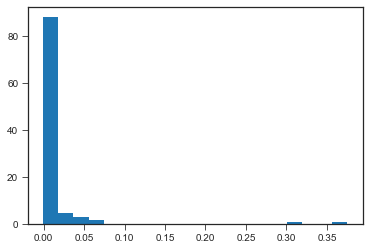

In [311]:
plt.hist(imps_mean, bins=20)

array([[<AxesSubplot:title={'center':'mean'}>]], dtype=object)

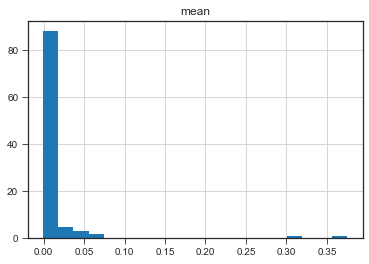

In [312]:
feat_imp_100 = pd.DataFrame(imps_mean, index=feats100, columns=['mean'])
feat_imp_100.hist(bins=20)

In [319]:
for i, metab in feat_imp_100.sort_values('mean', ascending=False).iterrows():
    print(i)
    

m_243
m_37
m_659
l_60
l_150
l_855
l_854
m_251
m_208
m_281
l_58
m_427
l_669
l_394
l_53
l_532
l_496
m_704
m_429
l_166
m_311
m_272
m_30
l_38
m_602
l_804
l_542
l_727
l_352
m_419
l_717
l_77
l_387
m_560
l_686
m_579
l_111
l_458
m_212
l_41
m_1
l_578
l_266
m_155
m_403
l_158
m_295
m_94
m_609
m_355
m_264
l_317
l_363
l_900
l_327
l_354
l_627
l_268
m_262
l_17
m_63
l_506
l_240
l_46
l_888
m_206
m_701
m_239
l_856
l_667
m_219
m_34
m_388
l_797
m_320
m_267
m_691
m_117
l_392
l_258
l_472
l_269
m_273
m_665
m_289
m_615
m_42
m_338
l_684
l_177
m_431
l_450
m_497
l_691
m_642
m_611
l_558
l_68
l_355
m_686


In [324]:
data.columns

Index(['Unique ID', 'Type', 'Proposed ID', 'Found in Tracefinder',
       'Compound Class', 'm/z', 'RT [min]', 'Area (Max.)', 'Score', 'Adduct',
       'Polarity', 'pval effect of glucose tolerance',
       'pval effect of sampling',
       'pval effect of interaction sampling and glucose tolerance',
       'fdr corrected pval effect of glucose tolerance',
       'fdr corrected pval effect of sampling',
       'fdr corrected pval effect of interaction sampling and glucose tolerance',
       '1076_10_FBG', '1062_8_FBG', '1093_9_FBG', '1060_8_RBG', '1091_10_FBG',
       '1092_9_RBG', '1093_10_RBG', '1082_10_FBG', '1060_9_RBG', '1101_9_FBG',
       '1062_10_RBG', '1091_8_RBG', '1074_10_FBG', '1101_10_RBG', '1076_9_FBG',
       '1092_9_FBG', '1074_8_FBG', '1091_10_RBG', '1082_9_FBG', '1076_8_RBG',
       '1060_8_FBG', '1093_9_RBG', '1060_10_FBG', '1082_10_RBG', '1074_9_RBG',
       '1091_9_RBG', '1101_10_FBG', '1093_8_FBG', '1074_8_RBG', '1102_10_RBG',
       '1062_9_FBG', '1076_9_RBG', '1

<AxesSubplot:>

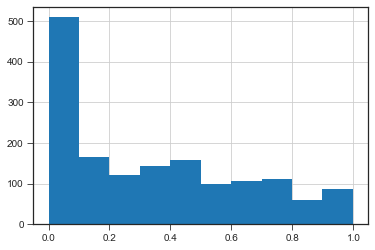

In [329]:
data['fdr corrected pval effect of glucose tolerance'].hist()

In [331]:
data.loc[feat_imp_100.index[:50], ['Unique ID', 'Type', 'Proposed ID', 'Compound Class', 'm/z', 'RT [min]', 
                                   'fdr corrected pval effect of glucose tolerance',
                                   'fdr corrected pval effect of sampling',
                                   'fdr corrected pval effect of interaction sampling and glucose tolerance']]

,Unique ID,Type,Proposed ID,Compound Class,m/z,RT [min],fdr corrected pval effect of glucose tolerance,fdr corrected pval effect of sampling,fdr corrected pval effect of interaction sampling and glucose tolerance
l_684,unknown_699.59631_13.7,lipid,unknown,unknown,699.59631,13.700,0.488789,5.321967e-01,0.674399
m_320,unknown_132.06564_14.211,metabolite,unknown,unknown,132.06564,14.211,0.462721,1.911075e-02,0.278098
l_17,unknown_448.99011_0.667,lipid,unknown,unknown,448.99011,0.667,0.123721,5.725244e-02,0.120558
l_46,unknown_622.29077_0.818,lipid,unknown,unknown,622.29077,0.818,0.926177,5.370027e-01,0.814888
l_53,unknown_343.99503_0.909,lipid,unknown,unknown,343.99503,0.909,0.013357,1.398443e-01,0.139430
l_38,unknown_480.92703_0.696,lipid,unknown,unknown,480.92703,0.696,0.345070,1.593352e-01,0.330061
l_856,unknown_753.52936_16.617,lipid,unknown,unknown,753.52936,16.617,0.101869,6.831008e-02,0.098024
m_579,unknown_614.9268_15.829,metabolite,unknown,unknown,614.92680,15.829,0.188071,1.080911e-02,0.215224
l_41,unknown_409.18292_0.715,lipid,unknown,unknown,409.18292,0.715,0.297244,7.064807e-01,0.655555
m_251,unknown_553.3249_2.919,metabolite,unknown,unknown,553.32490,2.919,0.033556,7.392331e-03,0.546273


In [333]:
fitted_rfr.feature_importances_

array([4.34129760e-03, 2.18508690e-03, 1.56975446e-03, 7.65208629e-04,
       2.74912307e-03, 1.68145871e-03, 5.43254644e-03, 2.17078670e-03,
       2.92096010e-03, 8.17375453e-03, 3.25249476e-02, 1.50949908e-02,
       1.11719260e-02, 8.70341047e-03, 1.22692340e-03, 1.01271259e-03,
       7.82335606e-04, 8.43712375e-04, 9.34461002e-03, 1.79052927e-02,
       1.51714405e-02, 9.33692736e-02, 2.23126393e-03, 3.24034099e-03,
       5.43912516e-03, 2.16878585e-03, 6.03607801e-04, 1.73211768e-03,
       2.84884134e-03, 3.18353758e-04, 7.98753064e-03, 7.89904643e-03,
       3.21412383e-03, 1.15559868e-02, 1.18490689e-03, 3.93575211e-04,
       8.14857772e-03, 9.74089029e-03, 1.39201166e-03, 1.13865054e-03,
       1.52855774e-03, 2.56778346e-03, 2.16589536e-01, 1.26734505e-03,
       3.19740422e-03, 3.62162817e-04, 2.61263613e-03, 3.63485586e-03,
       3.63683700e-04, 3.56735528e-04, 3.17616899e-03, 1.27011745e-02,
       4.15773726e-03, 3.51413959e-03, 1.22127873e-02, 2.52117258e-03,
      

In [336]:
test = RandomForestRegressor().fit(X_all, y_ogtt).feature_importances_

(array([1.717e+03, 6.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.        , 0.01768464, 0.03536928, 0.05305393, 0.07073857,
        0.08842321, 0.10610785, 0.1237925 , 0.14147714, 0.15916178,
        0.17684642, 0.19453107, 0.21221571, 0.22990035, 0.24758499,
        0.26526964, 0.28295428, 0.30063892, 0.31832356, 0.33600821,
        0.35369285]),
 <BarContainer object of 20 artists>)

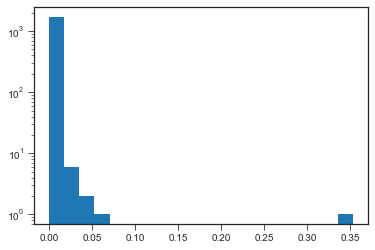

In [338]:
plt.hist(test, bins=20, log=True)

In [342]:
test2 = pd.Series(test)
print(sum(test2))
test2.loc[test2 > 0]

1.0000000000000002


2       0.001036
4       0.000165
6       0.000155
7       0.000190
8       0.000448
          ...   
1721    0.000036
1722    0.000021
1724    0.000148
1725    0.000145
1726    0.000017
Length: 754, dtype: float64

# Feature importance using CV and .feature_importances_ 
## Do RBG and FBG individually

In [12]:
X_rbg

i,l_0,l_1,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,...,m_682,m_368,m_340,m_616,m_557,m_169,m_213,m_24,m_505,m_441
1060_8_RBG,24.012349,25.685664,24.916555,25.977120,23.985839,27.293718,31.938325,22.246767,27.005584,24.827176,...,20.328434,22.667628,22.896178,20.147306,20.708589,24.568105,23.318774,27.795283,21.858665,22.537343
1092_9_RBG,23.901455,24.936916,24.162971,27.337061,23.184906,26.682437,30.690269,22.495336,26.325506,23.984926,...,20.422656,22.951906,23.100061,20.483145,21.073392,25.119634,23.268904,27.561589,21.397133,22.607897
1093_10_RBG,23.883301,24.779941,23.627979,27.415597,22.795191,26.236176,29.854529,22.337295,25.798043,23.349277,...,20.534701,23.038372,23.285365,20.589639,21.153981,25.008021,23.345351,27.863524,21.742171,22.614663
1060_9_RBG,24.421692,25.054941,23.169508,27.598719,22.397716,26.123572,29.717328,22.790052,25.559916,22.258087,...,18.750308,22.595668,22.718984,19.197231,20.482364,25.064357,17.810755,26.430616,18.004667,22.303816
1062_10_RBG,23.771262,24.929254,23.996330,27.467695,23.130926,26.662840,30.261612,22.606227,26.091143,23.329520,...,20.640384,23.091649,23.274696,20.681170,21.330772,24.739964,23.237501,27.982712,22.070432,22.711497
1091_8_RBG,24.251983,25.409805,24.305727,27.368441,22.860083,27.012252,30.297295,22.307839,26.217142,23.934218,...,20.452419,22.895389,22.972200,20.620950,21.038285,25.181198,23.783718,27.777985,21.721038,22.615136
1101_10_RBG,23.945171,25.059545,23.771498,27.946889,22.523599,26.642870,30.187898,22.498328,26.057555,23.542164,...,19.490593,22.594217,22.794755,20.274245,20.839097,25.107260,19.516898,26.920468,19.759563,22.303145
1091_10_RBG,23.594046,24.052896,21.770141,27.318509,21.371312,25.094165,29.553842,22.555152,25.212279,21.786229,...,20.802836,23.193567,23.327800,20.772223,21.152114,25.043350,23.499265,27.854002,21.943580,22.760029
1076_8_RBG,23.534959,24.548641,24.731989,27.298562,23.275046,26.601211,30.101470,22.171482,26.465361,23.646447,...,20.735784,22.972505,23.046029,21.054978,21.348797,24.539417,20.906036,27.407384,21.227446,22.402861
1093_9_RBG,24.214612,25.133202,24.241405,27.350003,23.296574,27.092660,30.390589,22.411484,26.284722,24.133213,...,20.501554,23.054384,23.245015,20.237077,20.902707,25.192015,23.348624,27.821637,21.795382,22.743003


In [23]:
# RBG
X_rbg = X_all.loc[rbg_cols]
y_ogtt_rbg = y_ogtt.loc[rbg_cols]
fi = np.array([0.0] * len(X_all.T))
for i, (train, test) in enumerate(RepeatedKFold(n_splits=10, n_repeats=30, random_state=1).split(X_rbg, y_ogtt_rbg)):
    model = RandomForestRegressor(n_estimators=1000, max_features=80, n_jobs=7)
    fi += model.fit(X_rbg.iloc[train], y_ogtt_rbg.iloc[train]).feature_importances_
    print(fi)
#     if i == 10:
#         break
# plt.hist(np.cbrt(fi/i), bins=20)

[2.83741174e-05 4.29851085e-06 2.89682998e-07 ... 4.83606808e-04
 4.78741858e-04 1.04921081e-04]
[7.06068548e-05 6.99424044e-05 2.76444696e-05 ... 1.35999042e-03
 1.33192962e-03 5.39259474e-04]
[7.77317028e-05 7.70209917e-05 5.79507636e-05 ... 2.41144368e-03
 2.04757523e-03 5.47136947e-04]
[0.00040039 0.00011039 0.00038408 ... 0.00265943 0.00258997 0.00115626]
[0.00059696 0.000114   0.00073581 ... 0.00364016 0.00332074 0.001304  ]
[0.00069314 0.0001379  0.00079742 ... 0.00444989 0.00404414 0.00166417]
[0.00069366 0.00013963 0.00094299 ... 0.00517579 0.0051457  0.00206768]
[0.0007544  0.00024746 0.00108157 ... 0.00593514 0.00551334 0.00226666]
[0.00077256 0.0002489  0.00108157 ... 0.00746391 0.00612201 0.00255284]
[0.0007824  0.00024899 0.00125845 ... 0.00821869 0.00636015 0.00301336]
[0.00116406 0.00025727 0.00126172 ... 0.00836133 0.00695295 0.00337597]
[0.00134173 0.00029084 0.00126172 ... 0.00978823 0.00717178 0.00343633]
[0.00136291 0.00029084 0.0013786  ... 0.01093479 0.00731163 0

[0.01249501 0.00523027 0.01115966 ... 0.08975957 0.07962179 0.0372041 ]
[0.01256234 0.00523027 0.01115966 ... 0.09024259 0.08024942 0.03754725]
[0.01256244 0.00523027 0.01116131 ... 0.09070535 0.08071832 0.0378039 ]
[0.01273584 0.00525142 0.01123632 ... 0.09126989 0.08162271 0.03807534]
[0.01282932 0.00528045 0.01126451 ... 0.0919599  0.08277361 0.03838862]
[0.01355816 0.00530146 0.01126451 ... 0.09260999 0.08413853 0.03866484]
[0.01382724 0.00549677 0.01136509 ... 0.09352933 0.08528101 0.03934313]
[0.013853   0.00551852 0.01143051 ... 0.09449978 0.08631059 0.04025198]
[0.01425016 0.00555386 0.01143063 ... 0.09462615 0.08715844 0.04047647]
[0.01442851 0.00555398 0.01145282 ... 0.09509024 0.08746462 0.04048509]
[0.01442851 0.00559306 0.01145287 ... 0.09963187 0.08863752 0.04094774]
[0.01449385 0.00562859 0.01145287 ... 0.10006267 0.08919476 0.04101898]
[0.01478847 0.00577645 0.0119706  ... 0.10057874 0.08939352 0.04145296]
[0.01479257 0.00577833 0.0119706  ... 0.10091804 0.09005108 0.04

[0.02643364 0.01194094 0.02002726 ... 0.16799224 0.16892396 0.07739518]
[0.02704685 0.01194512 0.02009074 ... 0.1686048  0.16922181 0.07803698]
[0.02707262 0.01195235 0.02009671 ... 0.16981173 0.1694562  0.07834483]
[0.02715031 0.0119943  0.02011254 ... 0.17022498 0.17053768 0.07834898]
[0.02729323 0.0119943  0.02012499 ... 0.17191136 0.17156599 0.07854163]
[0.02746262 0.01199563 0.02024249 ... 0.17208268 0.17160878 0.07872674]
[0.02754598 0.01218685 0.02025393 ... 0.17292858 0.17253538 0.07892495]
[0.0282337  0.01223062 0.02025393 ... 0.17348435 0.17390938 0.07938835]
[0.02846741 0.01229085 0.02049525 ... 0.17365758 0.17425397 0.0797571 ]
[0.02903276 0.0123124  0.02050002 ... 0.17463171 0.17477481 0.0813528 ]
[0.02922588 0.01232334 0.02052528 ... 0.17520768 0.17537663 0.08156606]
[0.02929085 0.01241143 0.02080461 ... 0.17572443 0.17679638 0.08158429]
[0.02929085 0.01241143 0.02080931 ... 0.17646536 0.17720005 0.08177402]
[0.02994291 0.01241499 0.02081636 ... 0.1773806  0.17794678 0.08

In [25]:
pd.DataFrame(fi, index=X_all.columns).to_csv(r'..\data\processed\Feature_Importance_RFReg_RBG.csv')

In [26]:
# FBG only
X_fbg = X_all.loc[fbg_cols]
y_ogtt_fbg = y_ogtt.loc[fbg_cols]
fi_fbg = np.array([0.0] * len(X_all.T))
for i, (train, test) in enumerate(RepeatedKFold(n_splits=10, n_repeats=30, random_state=1).split(X_fbg, y_ogtt_fbg)):
    model = RandomForestRegressor(n_estimators=1000, max_features=80, n_jobs=7)
    fi_fbg += model.fit(X_fbg.iloc[train], y_ogtt_fbg.iloc[train]).feature_importances_
    print(i, fi_fbg)
pd.DataFrame(fi_fbg, index=X_all.columns).to_csv(r'..\data\processed\Feature_Importance_RFReg_FBG.csv')

0 [3.29361069e-06 1.27278349e-06 6.04374585e-04 ... 6.13498693e-06
 2.97110697e-05 8.07953268e-06]
1 [2.27498323e-05 1.25953564e-04 1.34444550e-03 ... 1.13861206e-04
 5.76701822e-05 1.01728380e-05]
2 [0.00019382 0.00016133 0.00368488 ... 0.00013948 0.00013684 0.00127201]
3 [0.00020307 0.00037089 0.00403403 ... 0.00046358 0.00013836 0.00127322]
4 [0.00034082 0.00059439 0.00426099 ... 0.00050402 0.00018196 0.00210319]
5 [0.00055434 0.00062793 0.00483283 ... 0.00053389 0.0003085  0.00217966]
6 [0.00078697 0.00066907 0.00510255 ... 0.00053398 0.00033994 0.00218024]
7 [0.00081764 0.00067041 0.00553774 ... 0.00056472 0.00035086 0.00224339]
8 [0.00082927 0.00077854 0.00618644 ... 0.00056623 0.00035305 0.00224463]
9 [0.00084682 0.00094085 0.00640425 ... 0.00062098 0.00043389 0.00224641]
10 [0.00103631 0.00094368 0.00662556 ... 0.00078775 0.00048645 0.00224701]
11 [0.00105394 0.00096031 0.00668555 ... 0.00079124 0.00050814 0.00226935]
12 [0.00118957 0.0009661  0.00725543 ... 0.00079142 0.000529

109 [0.01010229 0.00550241 0.05512763 ... 0.00597096 0.0038132  0.01066678]
110 [0.0101087  0.00574816 0.05570663 ... 0.00602582 0.00388314 0.01068997]
111 [0.01026941 0.00580857 0.05597353 ... 0.00630143 0.00391837 0.01072698]
112 [0.01029499 0.00591433 0.05633368 ... 0.00636276 0.00392895 0.01072705]
113 [0.01045431 0.00592216 0.05682468 ... 0.00640033 0.003931   0.01083747]
114 [0.01055577 0.00602571 0.0570427  ... 0.00643708 0.00393261 0.01106758]
115 [0.01066954 0.00604372 0.05744676 ... 0.00646847 0.00394925 0.01106973]
116 [0.01074048 0.00609655 0.0579023  ... 0.00647028 0.00402093 0.01109512]
117 [0.01075013 0.00610142 0.05804142 ... 0.00712129 0.00404689 0.01111051]
118 [0.01075717 0.00610153 0.05884966 ... 0.00713825 0.00409236 0.01114896]
119 [0.01091768 0.00610676 0.05885761 ... 0.00713825 0.00409875 0.01115086]
120 [0.01091768 0.00611124 0.05933833 ... 0.00714489 0.00409923 0.0111514 ]
121 [0.01114121 0.00621218 0.05947328 ... 0.0071522  0.00413425 0.0111589 ]
122 [0.01114

217 [0.02044598 0.0112782  0.10138532 ... 0.01275503 0.00811198 0.01960555]
218 [0.02046233 0.01130767 0.10154088 ... 0.01277221 0.00812968 0.01971876]
219 [0.02072748 0.01136158 0.10212726 ... 0.01278662 0.00823423 0.01997278]
220 [0.02135253 0.01137637 0.10257733 ... 0.01283821 0.00823907 0.02014519]
221 [0.02145905 0.0113815  0.10327947 ... 0.01290363 0.00828157 0.02016817]
222 [0.02147786 0.01139105 0.10414801 ... 0.01327818 0.00828831 0.02022776]
223 [0.02151237 0.0114024  0.10433503 ... 0.01334941 0.0082979  0.02023993]
224 [0.02151516 0.01144377 0.10454056 ... 0.01335154 0.00842407 0.02028813]
225 [0.02156796 0.01155048 0.10457145 ... 0.01350085 0.0085024  0.02045083]
226 [0.02162547 0.01155253 0.10463109 ... 0.01350535 0.00859806 0.02054713]
227 [0.02163116 0.01169284 0.10492559 ... 0.01351508 0.0086835  0.02055022]
228 [0.02175936 0.01169284 0.10559873 ... 0.01358946 0.0086835  0.02059103]
229 [0.02185635 0.0117033  0.10687344 ... 0.01361626 0.00868605 0.02064317]
230 [0.02253

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_ogtt, random_state=1)
fitted_rfr = RandomForestRegressor(n_estimators=1000, max_features=80, random_state=1).fit(X_all, y_ogtt)

In [22]:
pd.DataFrame(fitted_rfr.feature_importances_, index=X_all.columns).to_csv(r'..\data\processed\RandomForestRegressor_feature_importances.csv')